# Import dependencies and libraries

In [2]:
import os
import json
import pickle as pickle

import geopandas as gpd
import pandas as pd
import numpy as np

# for fitting empirical distributions for radius of gyration and jump length
import powerlaw
# for fetching osm data
import osmnx as ox

# for visualization
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# trackintel -> the functions will be imported with full names
import trackintel as ti


In [3]:
# options for better printing and visualizing

colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]

matplotlib.rcParams["figure.dpi"] = 300
matplotlib.rcParams["xtick.labelsize"] = 13
matplotlib.rcParams["ytick.labelsize"] = 13
np.set_printoptions(precision=4)
np.set_printoptions(suppress=True)

%matplotlib inline

In [4]:
# get the data dir from the config file -> default stored in Data/Geolife/Data folder

DATA_DIR = os.path.join("..", "paths.json")
with open(DATA_DIR) as json_file:
    CONFIG = json.load(json_file)

save_dir = os.path.join("..", CONFIG["data_dir"])

# Read files

## Reading Selected Geolife users

In [ ]:
selected_pfs = ti.read_positionfixes_csv(os.path.join(save_dir, "selected_geolife_pfs.csv"), index_col="id")
selected_mode_labels = pickle.load(open(os.path.join(save_dir, "selected_mode_labels.pk"), "rb"))

# validate
len(selected_pfs), selected_mode_labels.keys()

## Reading your own data
Trackintel provides an I/O module for accessing movement data and storing intermediate or final results in a file or database. Three methods for converting movement data with attached attribute information to Trackintel-compatible formats are provided: 1) Reading from Pandas Dataframes and Geopandas Geodataframes, 2) reading and writing from CSV file formats, and 3) reading and storing from PostgreSQL databases with PostGIS extension. Check the [input/output](https://trackintel.readthedocs.io/en/latest/modules/io.html) module for more information. 

An important consideration before loading data is to find the appropriate movement level for your data. Depending on the semantics of the data, you should call different reading functions, e.g., [read_positionfixes_csv](https://trackintel.readthedocs.io/en/latest/modules/io.html#trackintel.io.read_positionfixes_csv) or [read_staypoints_csv](https://trackintel.readthedocs.io/en/latest/modules/io.html#trackintel.io.read_staypoints_csv). We provide a reference of the different data types in the figure below:

[A Figure]

In [9]:
# use ti.read_positionfixes_csv() or ti.read_staypoints_csv() for loading your data. Check the documentation for the required input parameters

# 1. Calculate tracking quality

## Generate staypoints and trips 

In [6]:
# generate staypoints, triplegs and trips
pfs, sp = selected_pfs.generate_staypoints(gap_threshold=24 * 60, include_last=True, print_progress=True, dist_threshold=200, time_threshold=30, n_jobs=-1)

# create activity flag
sp = sp.create_activity_flag(method="time_threshold", time_threshold=25)

# generate triplegs
pfs, tpls = pfs.generate_triplegs(sp, gap_threshold=15, print_progress=True)

# generate trips
sp, tpls, trips = sp.generate_trips(tpls, add_geometry=False)

c:\ProgramData\Anaconda3\envs\reprotrack\lib\site-packages\trackintel\preprocessing\positionfixes.py:113: UserWarning: 1690 duplicates were dropped from your positionfixes. Dropping duplicates is recommended but can be prevented using the 'exclude_duplicate_pfs' flag.
  warnings.warn(warn_str)
100%|██████████| 20/20 [00:00<00:00, 55.24it/s]
c:\ProgramData\Anaconda3\envs\reprotrack\lib\site-packages\trackintel\preprocessing\positionfixes.py:508: UserWarning: The positionfixes with ids [2894106 2894107 3826247 3826248] lead to invalid tripleg geometries. The resulting triplegs were omitted and the tripleg id of the positionfixes was set to nan
  warnings.warn(warn_string)


## Calculate tracking quality

In [7]:
# prepare for calculating the tracking quality

trips["started_at"] = pd.to_datetime(trips["started_at"]).dt.tz_localize(None)
trips["finished_at"] = pd.to_datetime(trips["finished_at"]).dt.tz_localize(None)
sp["started_at"] = pd.to_datetime(sp["started_at"]).dt.tz_localize(None)
sp["finished_at"] = pd.to_datetime(sp["finished_at"]).dt.tz_localize(None)

# merge trips and staypoints
print("starting merge", sp.shape, trips.shape)
sp["type"] = "sp"
trips["type"] = "tpl"
df_all = pd.concat([sp, trips])
df_all = ti.analysis.tracking_quality._split_overlaps(df_all, granularity="day")
df_all["duration"] = (df_all["finished_at"] - df_all["started_at"]).dt.total_seconds()
print("finished merge", df_all.shape)
print("*" * 50)

print("Total user number: ", len(df_all["user_id"].unique()))

starting merge (5182, 8) (5531, 5)
finished merge (11985, 12)
**************************************************
Total user number:  20


### Overall quality

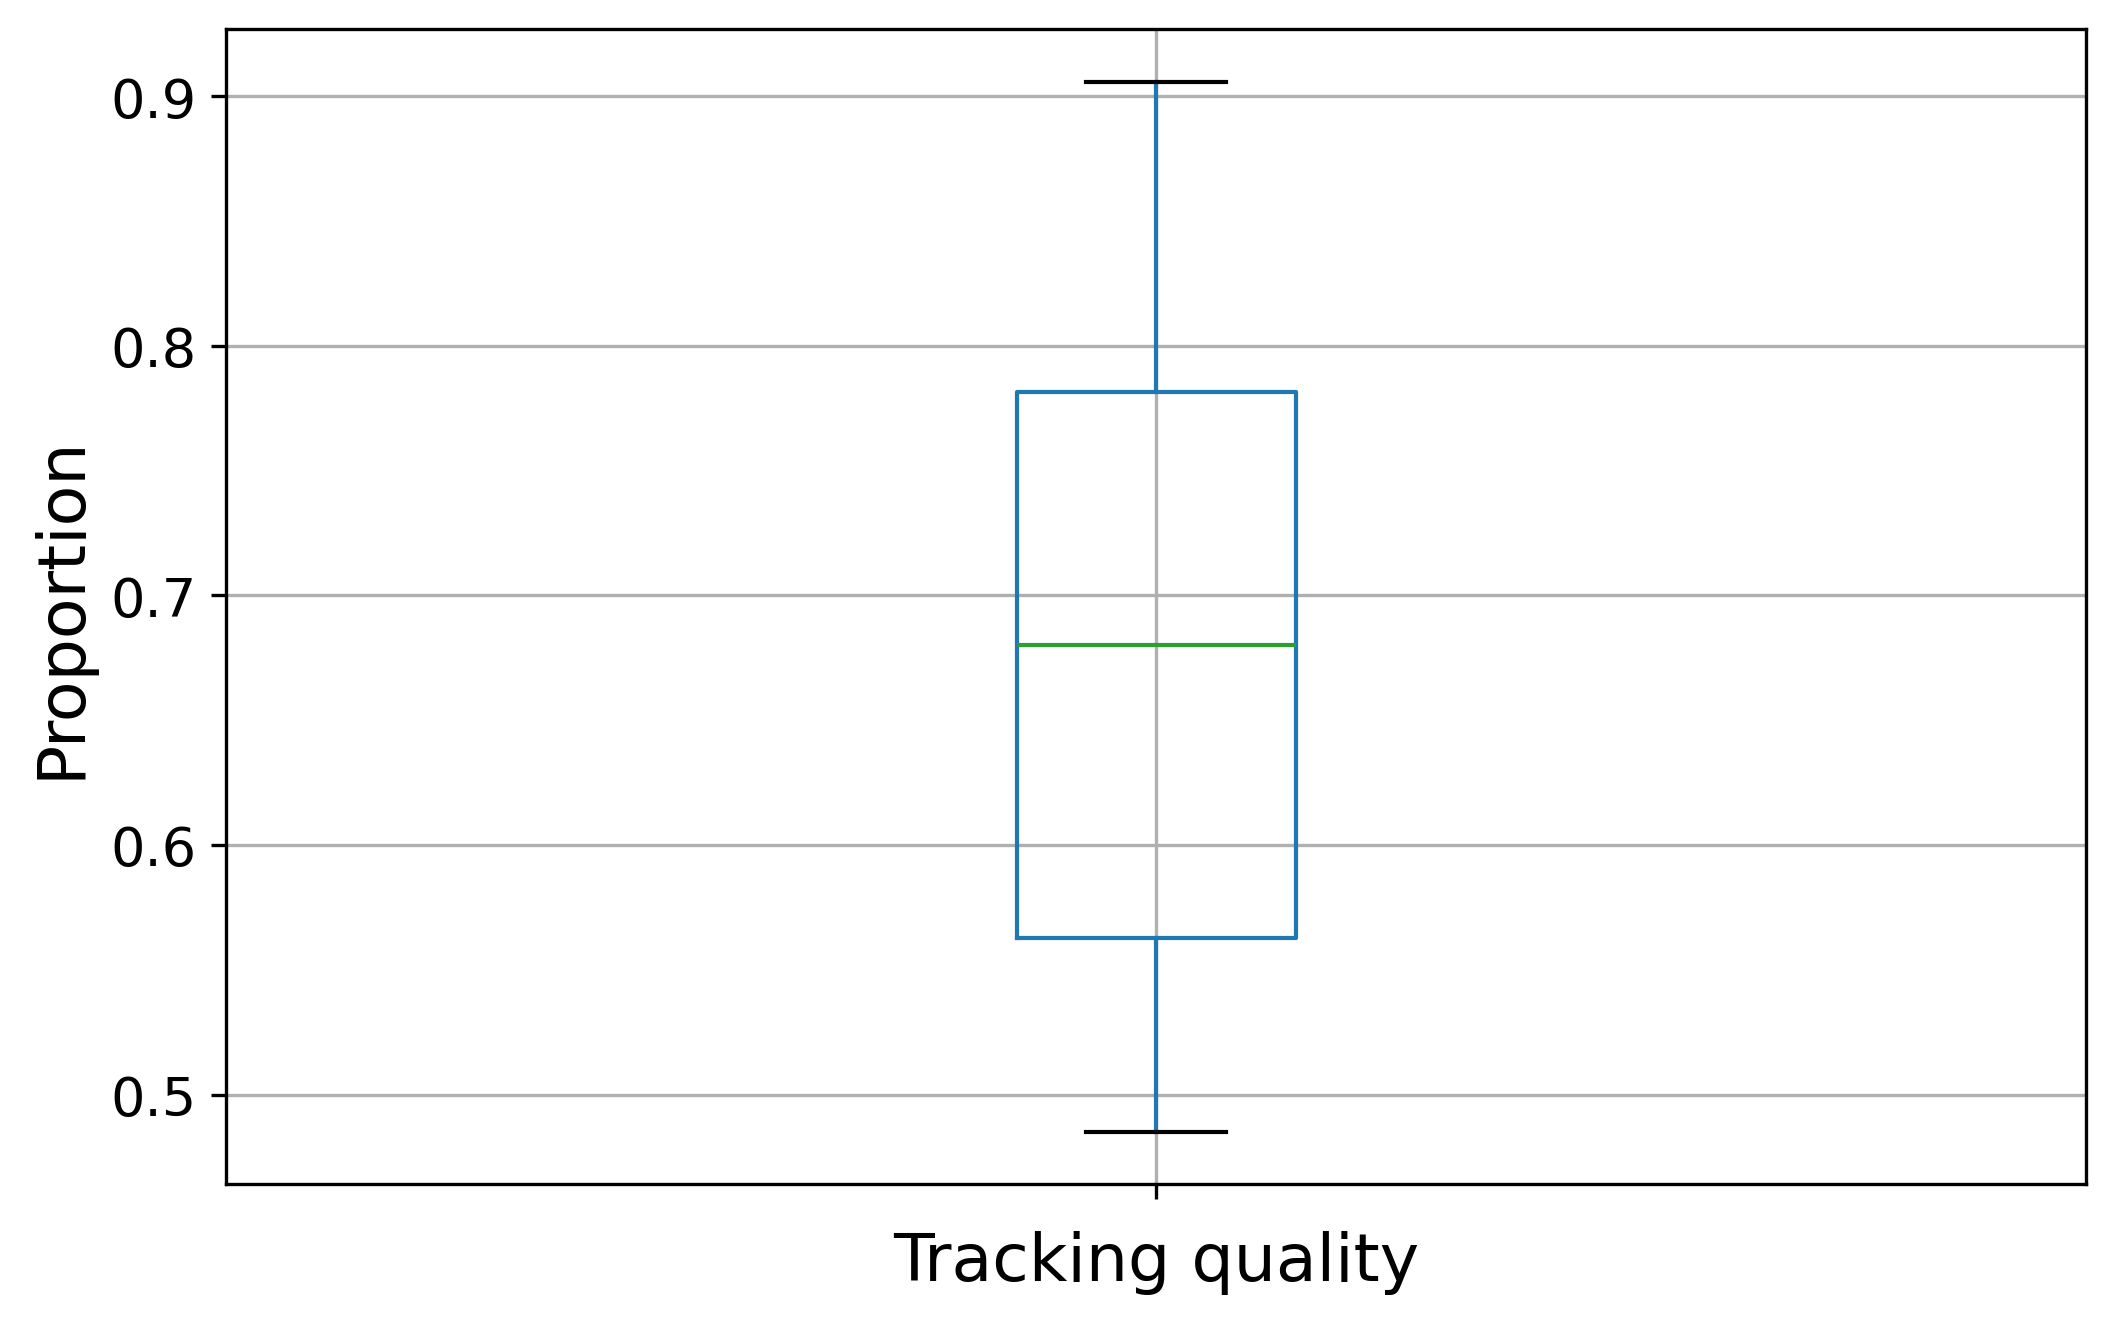

In [8]:
# get quality
total_quality = ti.analysis.temporal_tracking_quality(df_all, granularity="all")

boxplot = total_quality.boxplot(column="quality", figsize=(8, 5))

boxplot.set_xticklabels([])

plt.xlabel("Tracking quality", fontsize=16)
plt.ylabel("Proportion", fontsize=16)
plt.show()

### Quality by week

In [9]:
# get quality
week_quality = ti.analysis.temporal_tracking_quality(df_all, granularity="week")

week_quality_user = week_quality.loc[week_quality["quality"] != 0].groupby("week_monday", as_index=False)["quality"].median()

# construct the index
week_quality_user.set_index("week_monday",inplace=True)

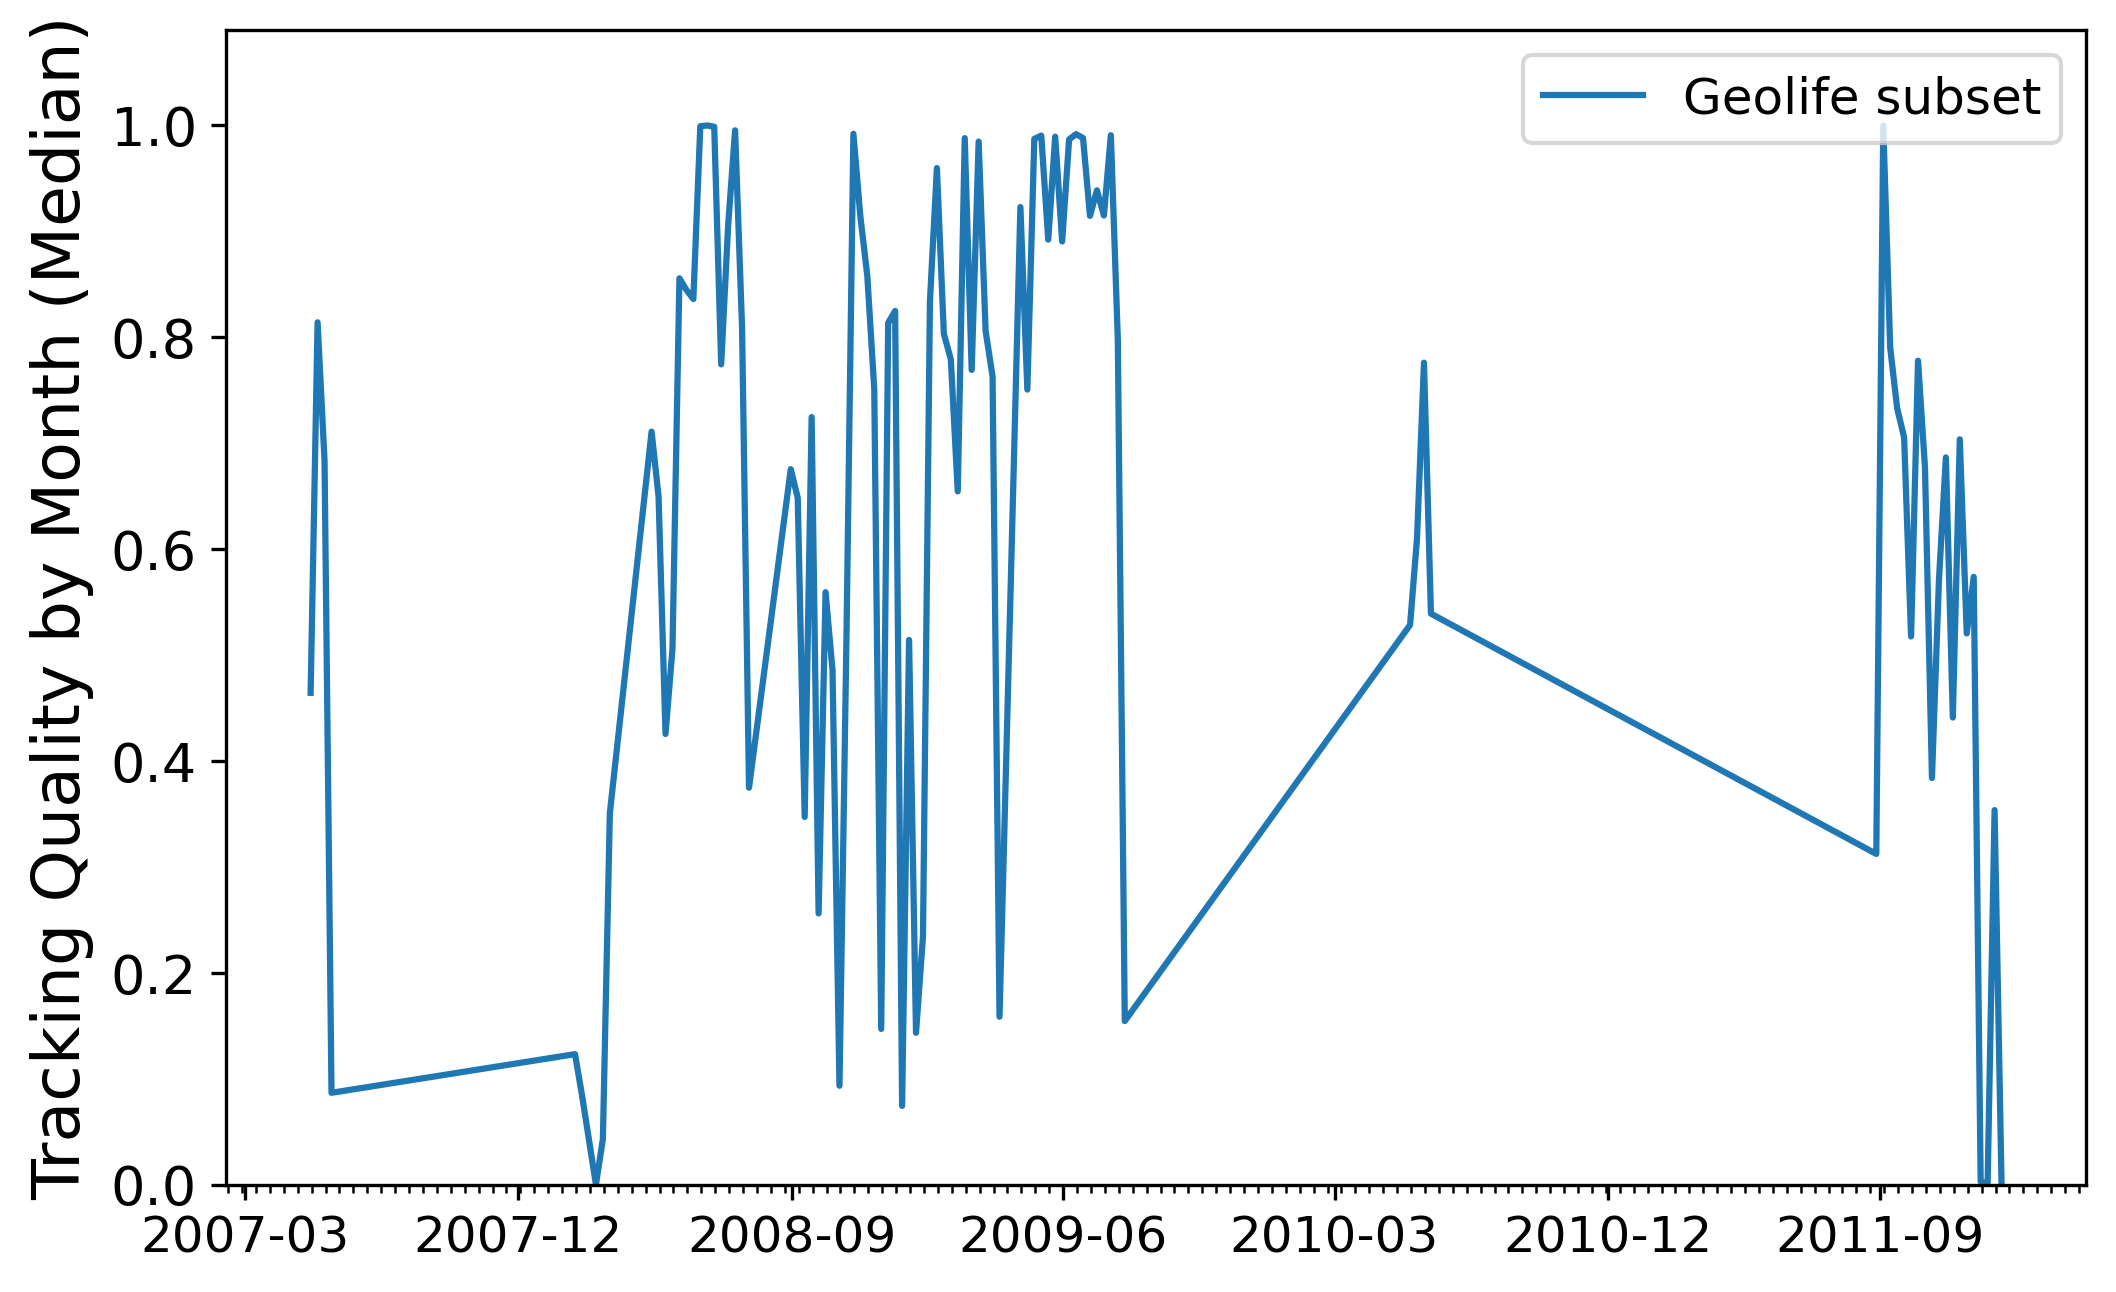

In [10]:
fig, ax = plt.subplots(figsize=(8, 5))

ax.plot(week_quality_user.index, week_quality_user['quality'], label="Geolife subset", color=colors[0])
ax.set_ylabel("Tracking Quality by Month (Median)", fontsize=16)
ax.set_xlabel("", fontsize=16)

ax.xaxis.set_minor_locator(mdates.DayLocator(interval=14))
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=9))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))

ax.tick_params(axis='x', which='major', labelsize=12)

ax.set_ylim([0, 1.09])
ax.legend(prop={'size': 12}, loc = 'upper right')

plt.show()

### Quality by day

In [11]:
# get quality
day_quality = ti.analysis.temporal_tracking_quality(df_all, granularity="day")

day_quality_user = day_quality.loc[day_quality["quality"] != 0].groupby("day", as_index=False)["quality"].median()
# construct the index
day_quality_user.set_index("day",inplace=True)

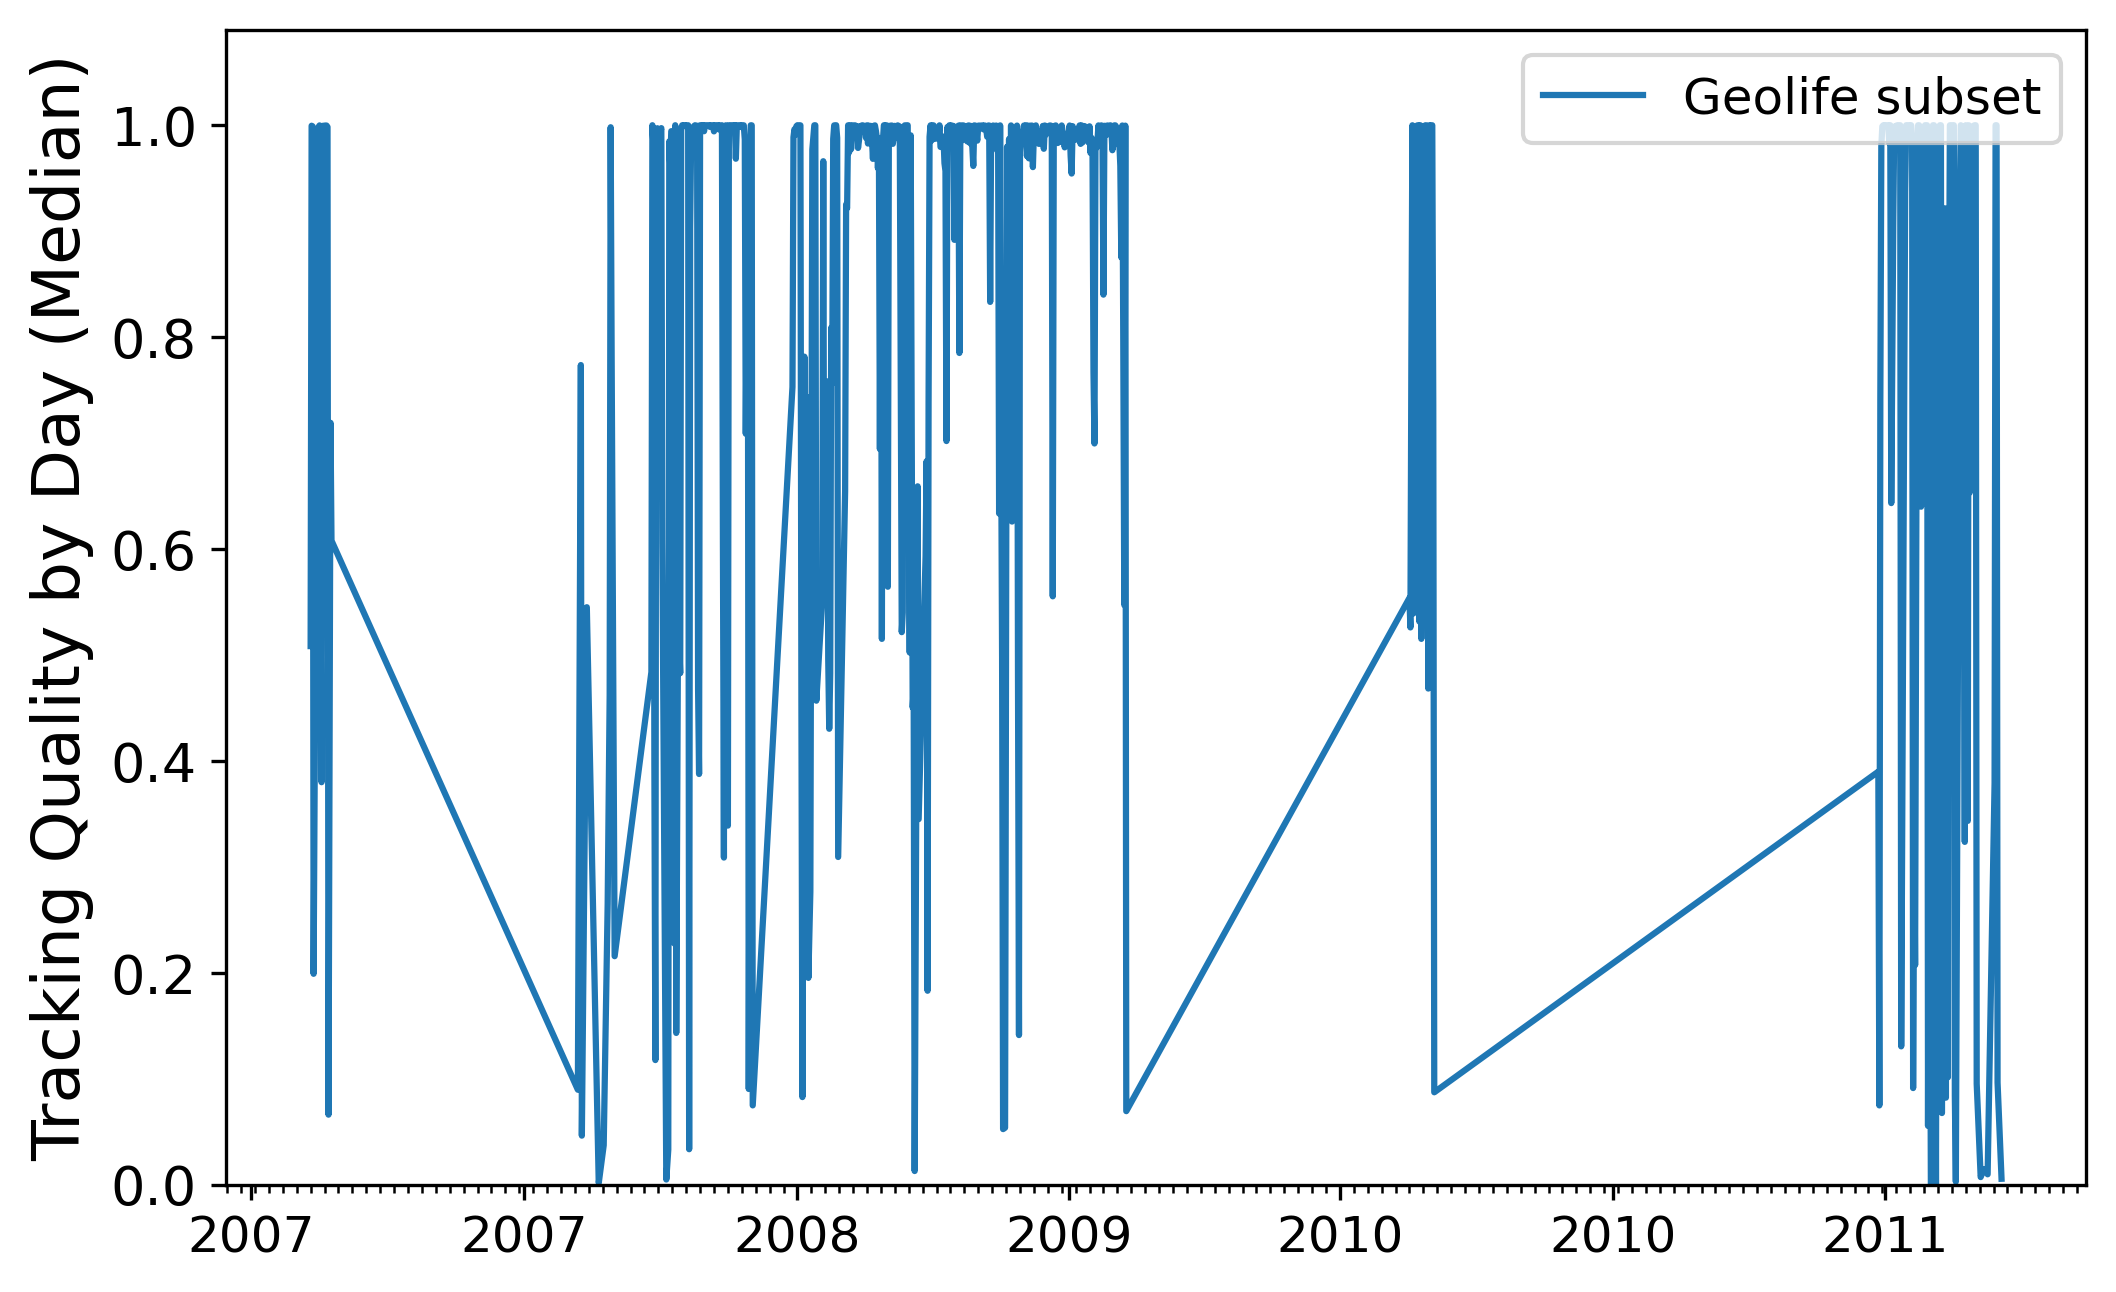

In [12]:
fig, ax = plt.subplots(figsize=(8, 5))

ax.plot(day_quality_user.index, day_quality_user['quality'], label="Geolife subset", color=colors[0])
ax.set_ylabel("Tracking Quality by Day (Median)", fontsize=16)
ax.set_xlabel("", fontsize=16)

ax.xaxis.set_minor_locator(mdates.DayLocator(interval=14))
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=9))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))

ax.tick_params(axis='x', which='major', labelsize=12)

ax.set_ylim([0, 1.09])
ax.legend(prop={'size': 12}, loc = 'upper right')

plt.show()

### Quality by weekday

In [13]:
# get quality
weekday_quality = ti.analysis.temporal_tracking_quality(df_all, granularity="weekday")

weekday_quality_user = weekday_quality.loc[weekday_quality["quality"] != 0].groupby("weekday", as_index=False)["quality"].median()

weekday_quality_user.set_index("weekday",inplace=True)

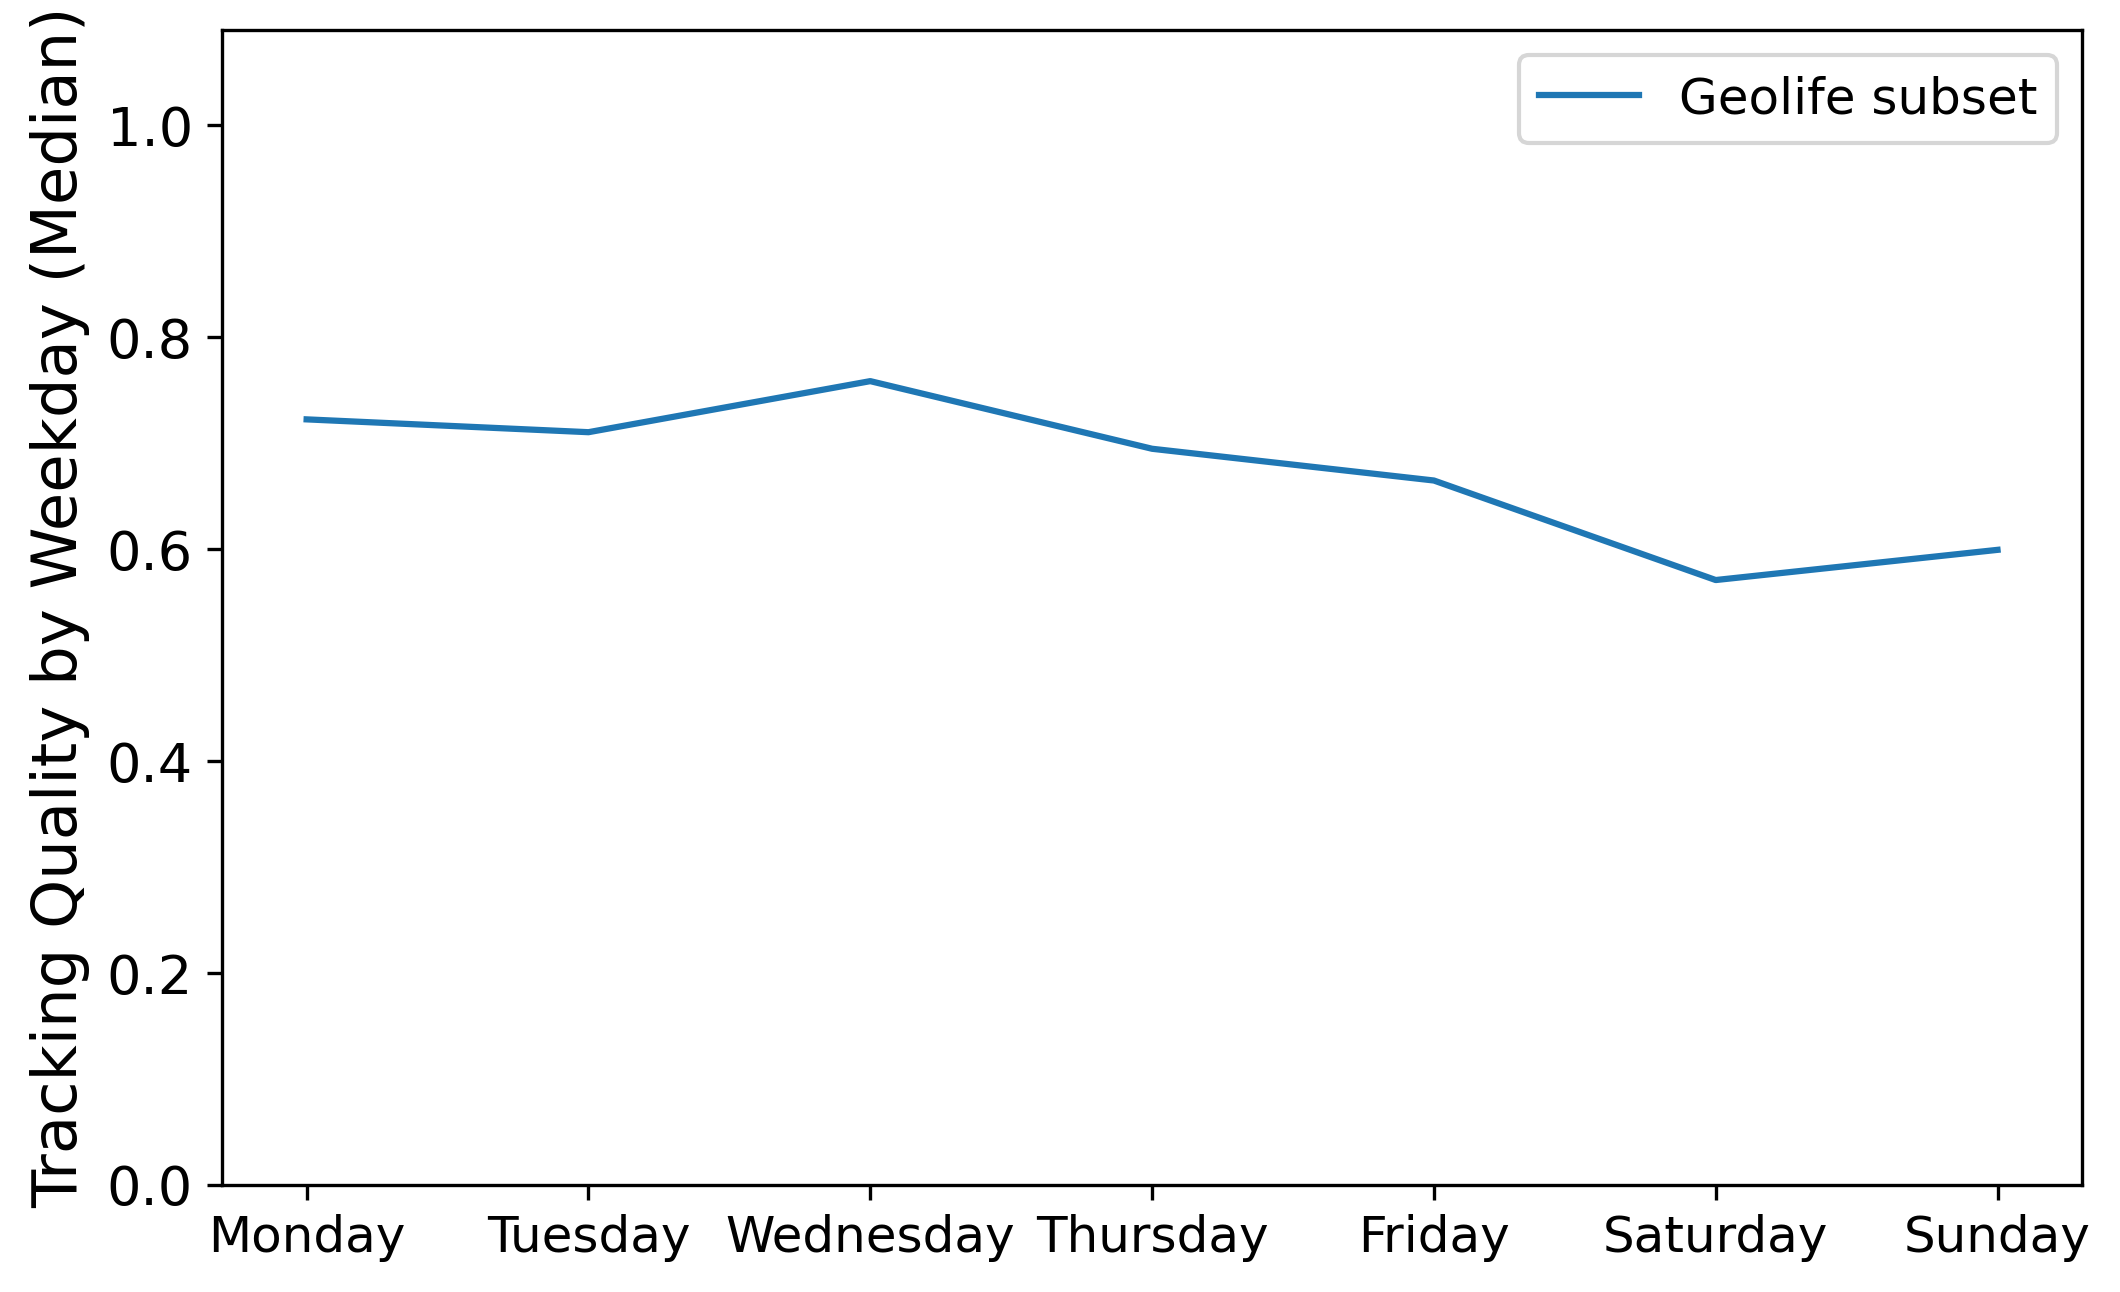

In [14]:
fig, ax = plt.subplots(figsize=(8, 5))

ax.plot(weekday_quality_user.index, weekday_quality_user['quality'], label="Geolife subset", color=colors[0])
ax.set_ylabel("Tracking Quality by Weekday (Median)", fontsize=15)
ax.set_xlabel("", fontsize=15)

ax.tick_params(axis='x', which='major', labelsize=12)

ax.set_ylim([0, 1.09])
ax.set_xticks(np.arange(7), labels= ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"])

ax.legend(prop={'size': 12}, loc = 'upper right')

plt.show()

### Quality by hour

In [15]:
# get quality
hour_quality = ti.analysis.temporal_tracking_quality(df_all, granularity="hour")

hour_quality_user = hour_quality.loc[hour_quality["quality"] != 0].groupby("hour", as_index=False)["quality"].median()

hour_quality_user.set_index("hour",inplace=True)

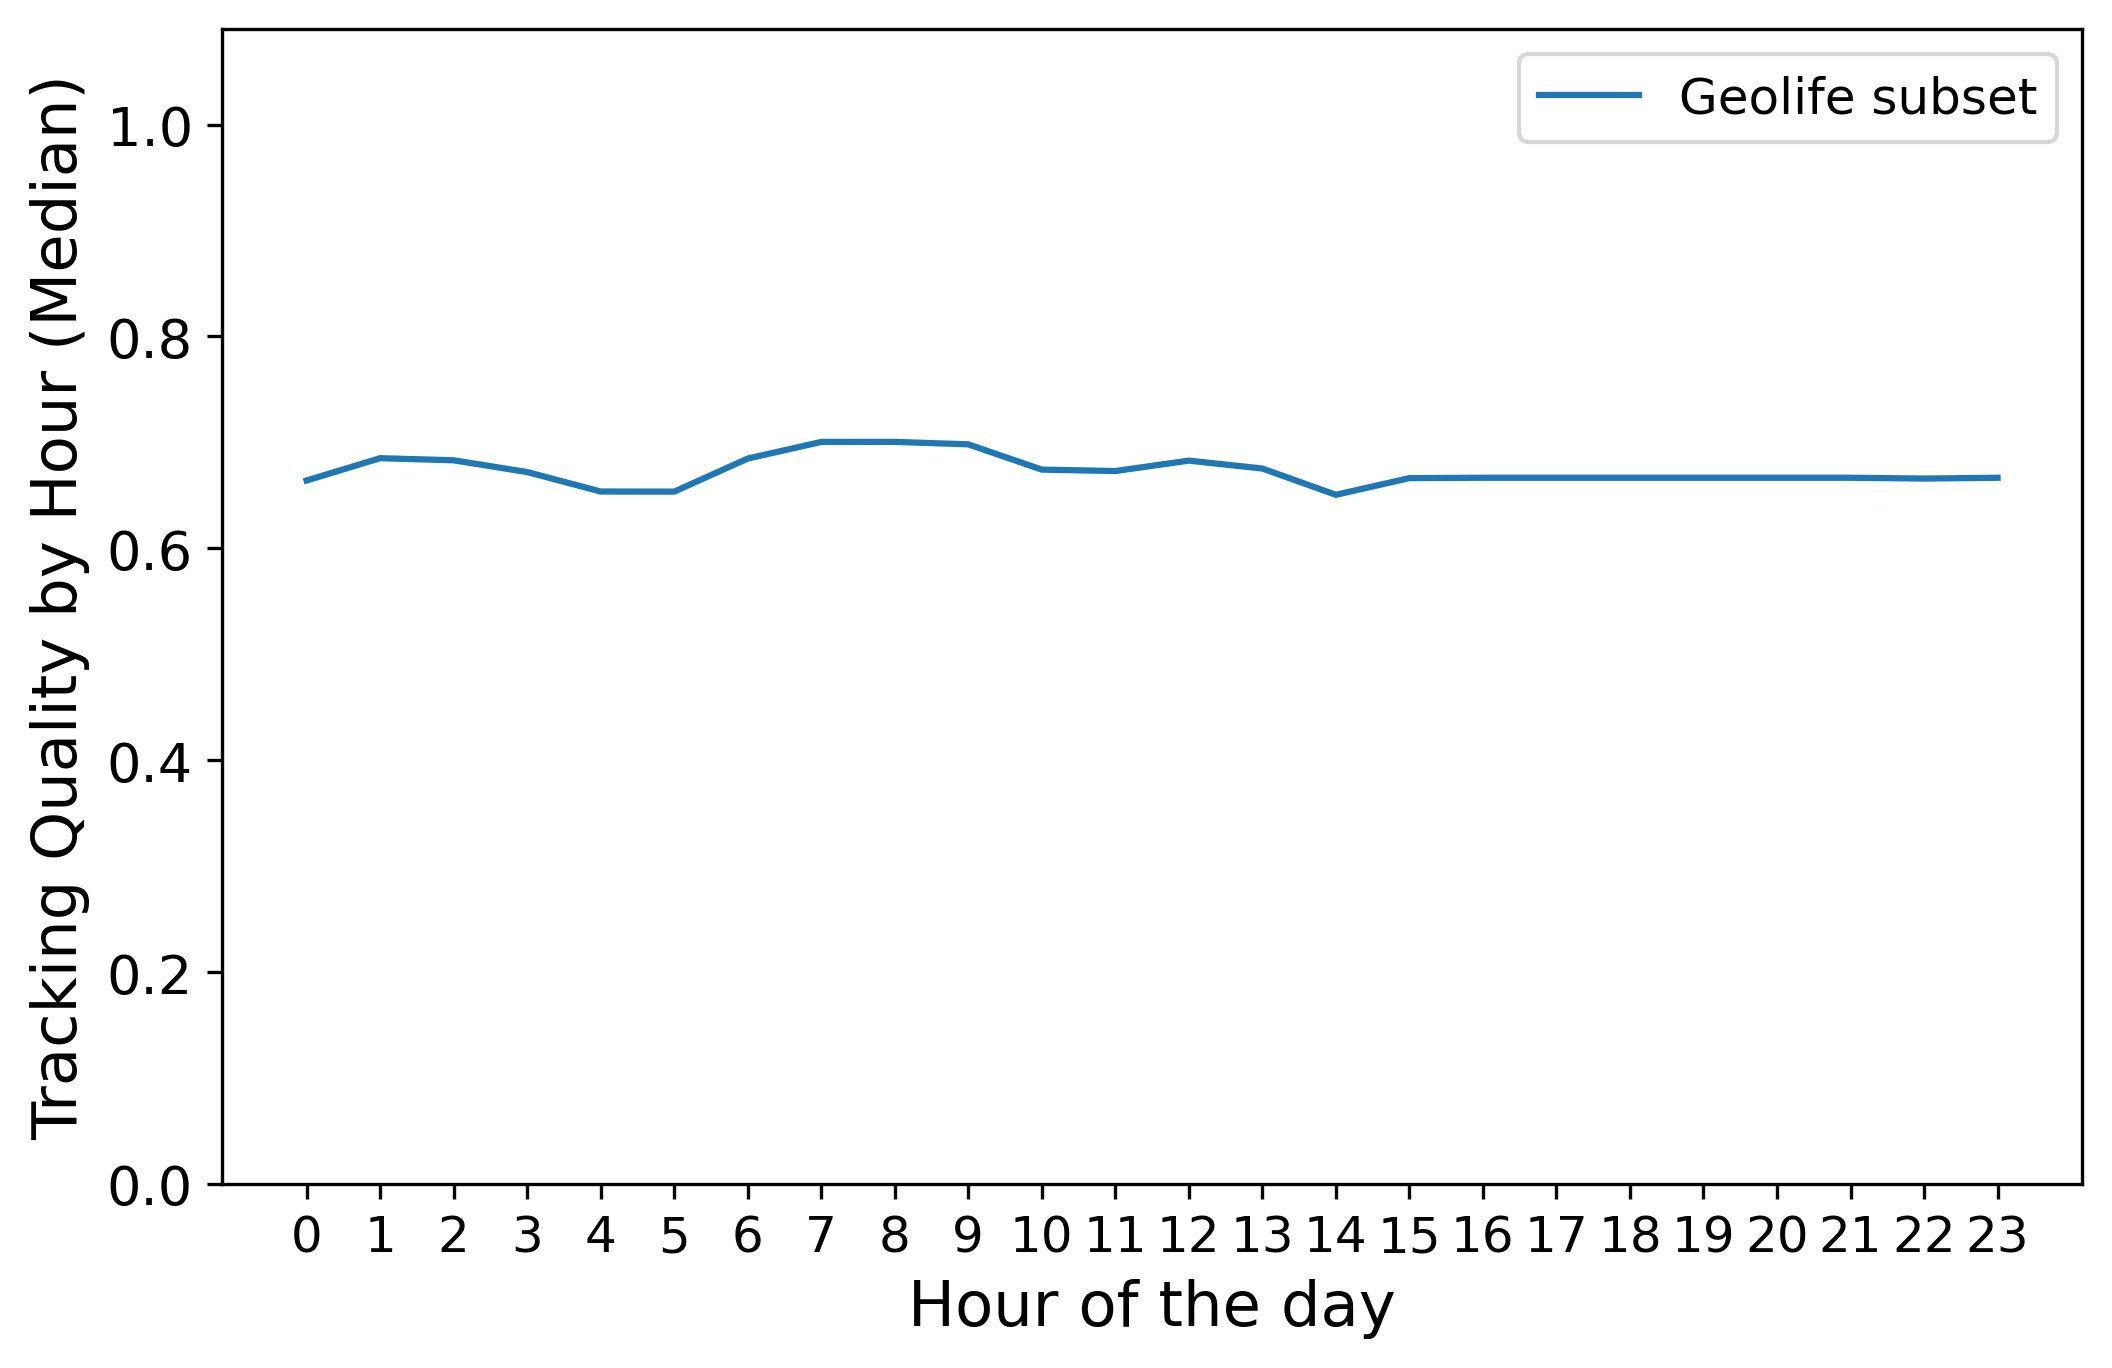

In [16]:
fig, ax = plt.subplots(figsize=(8, 5))

ax.plot(hour_quality_user.index, hour_quality_user['quality'], label="Geolife subset", color=colors[0])
ax.set_ylabel("Tracking Quality by Hour (Median)", fontsize=15)
ax.set_xlabel("", fontsize=15)

ax.tick_params(axis='x', which='major', labelsize=12)

ax.set_ylim([0, 1.09])
ax.set_xticks(np.arange(24))
ax.set_xlabel("Hour of the day", fontsize=15)

ax.legend(prop={'size': 12}, loc = 'upper right')

plt.show()

# 2. Calculate travel mode split
## Read files

In [8]:
selected_pfs = ti.read_positionfixes_csv(os.path.join(save_dir, "selected_geolife_pfs.csv"), index_col="id", crs="EPSG:4326")
selected_mode_labels = pickle.load(open(os.path.join(save_dir, "selected_mode_labels.pk"), "rb"))

# validate
len(selected_pfs), selected_mode_labels.keys()

(4396670, dict_keys([20, 112, 154]))

## Generate staypoints and triplegs

In [8]:
# generate staypoints, triplegs and trips
pfs, sp = selected_pfs.generate_staypoints(gap_threshold=24 * 60, include_last=True, print_progress=True, dist_threshold=200, time_threshold=30, n_jobs=-1)

# create activity flag
sp = sp.create_activity_flag(method="time_threshold", time_threshold=25)

# generate triplegs
pfs, tpls = pfs.generate_triplegs(sp, gap_threshold=15, print_progress=True)

c:\ProgramData\Anaconda3\envs\reprotrack\lib\site-packages\trackintel\preprocessing\positionfixes.py:113: UserWarning: 1690 duplicates were dropped from your positionfixes. Dropping duplicates is recommended but can be prevented using the 'exclude_duplicate_pfs' flag.
  warnings.warn(warn_str)
100%|██████████| 20/20 [00:00<00:00, 56.96it/s]
c:\ProgramData\Anaconda3\envs\reprotrack\lib\site-packages\trackintel\preprocessing\positionfixes.py:508: UserWarning: The positionfixes with ids [2894106 2894107 3826247 3826248] lead to invalid tripleg geometries. The resulting triplegs were omitted and the tripleg id of the positionfixes was set to nan
  warnings.warn(warn_string)


## Attach mode labels to triplegs - true labels and mode detection based on speed

In [9]:
# assign the true mode labels to triplegs, with the help of trackintel functions
tpls = ti.io.geolife_add_modes_to_triplegs(tpls, selected_mode_labels)



In [ ]:
# impute the mode of the other triplegs based on speed 
tpls["pred_mode"] = ti.analysis.predict_transport_mode(tpls)["mode"]
tpls.loc[tpls["mode"].isna(), "mode"] = tpls.loc[tpls["mode"].isna(), "pred_mode"]
tpls.drop(columns={"pred_mode"}, inplace=True)

In [10]:
mode_to_category = {
    "fast_mobility": "fast",
    "car": "motorized",
    "bus": "motorized",
    "taxi": "motorized",
    "ecar": "motorized",
    "motorized_mobility": "motorized",
    "bike": "slow",
    "walk": "slow",
    "slow_mobility": "slow",
}

# change mode labels with the above mapping
tpls["mode"] = tpls["mode"].map(mode_to_category)
tpls.dropna(subset=["mode"], inplace=True)
tpls["mode"].value_counts()

mode
slow         3460
motorized    2032
fast           37
Name: count, dtype: int64

## Visualize modal split

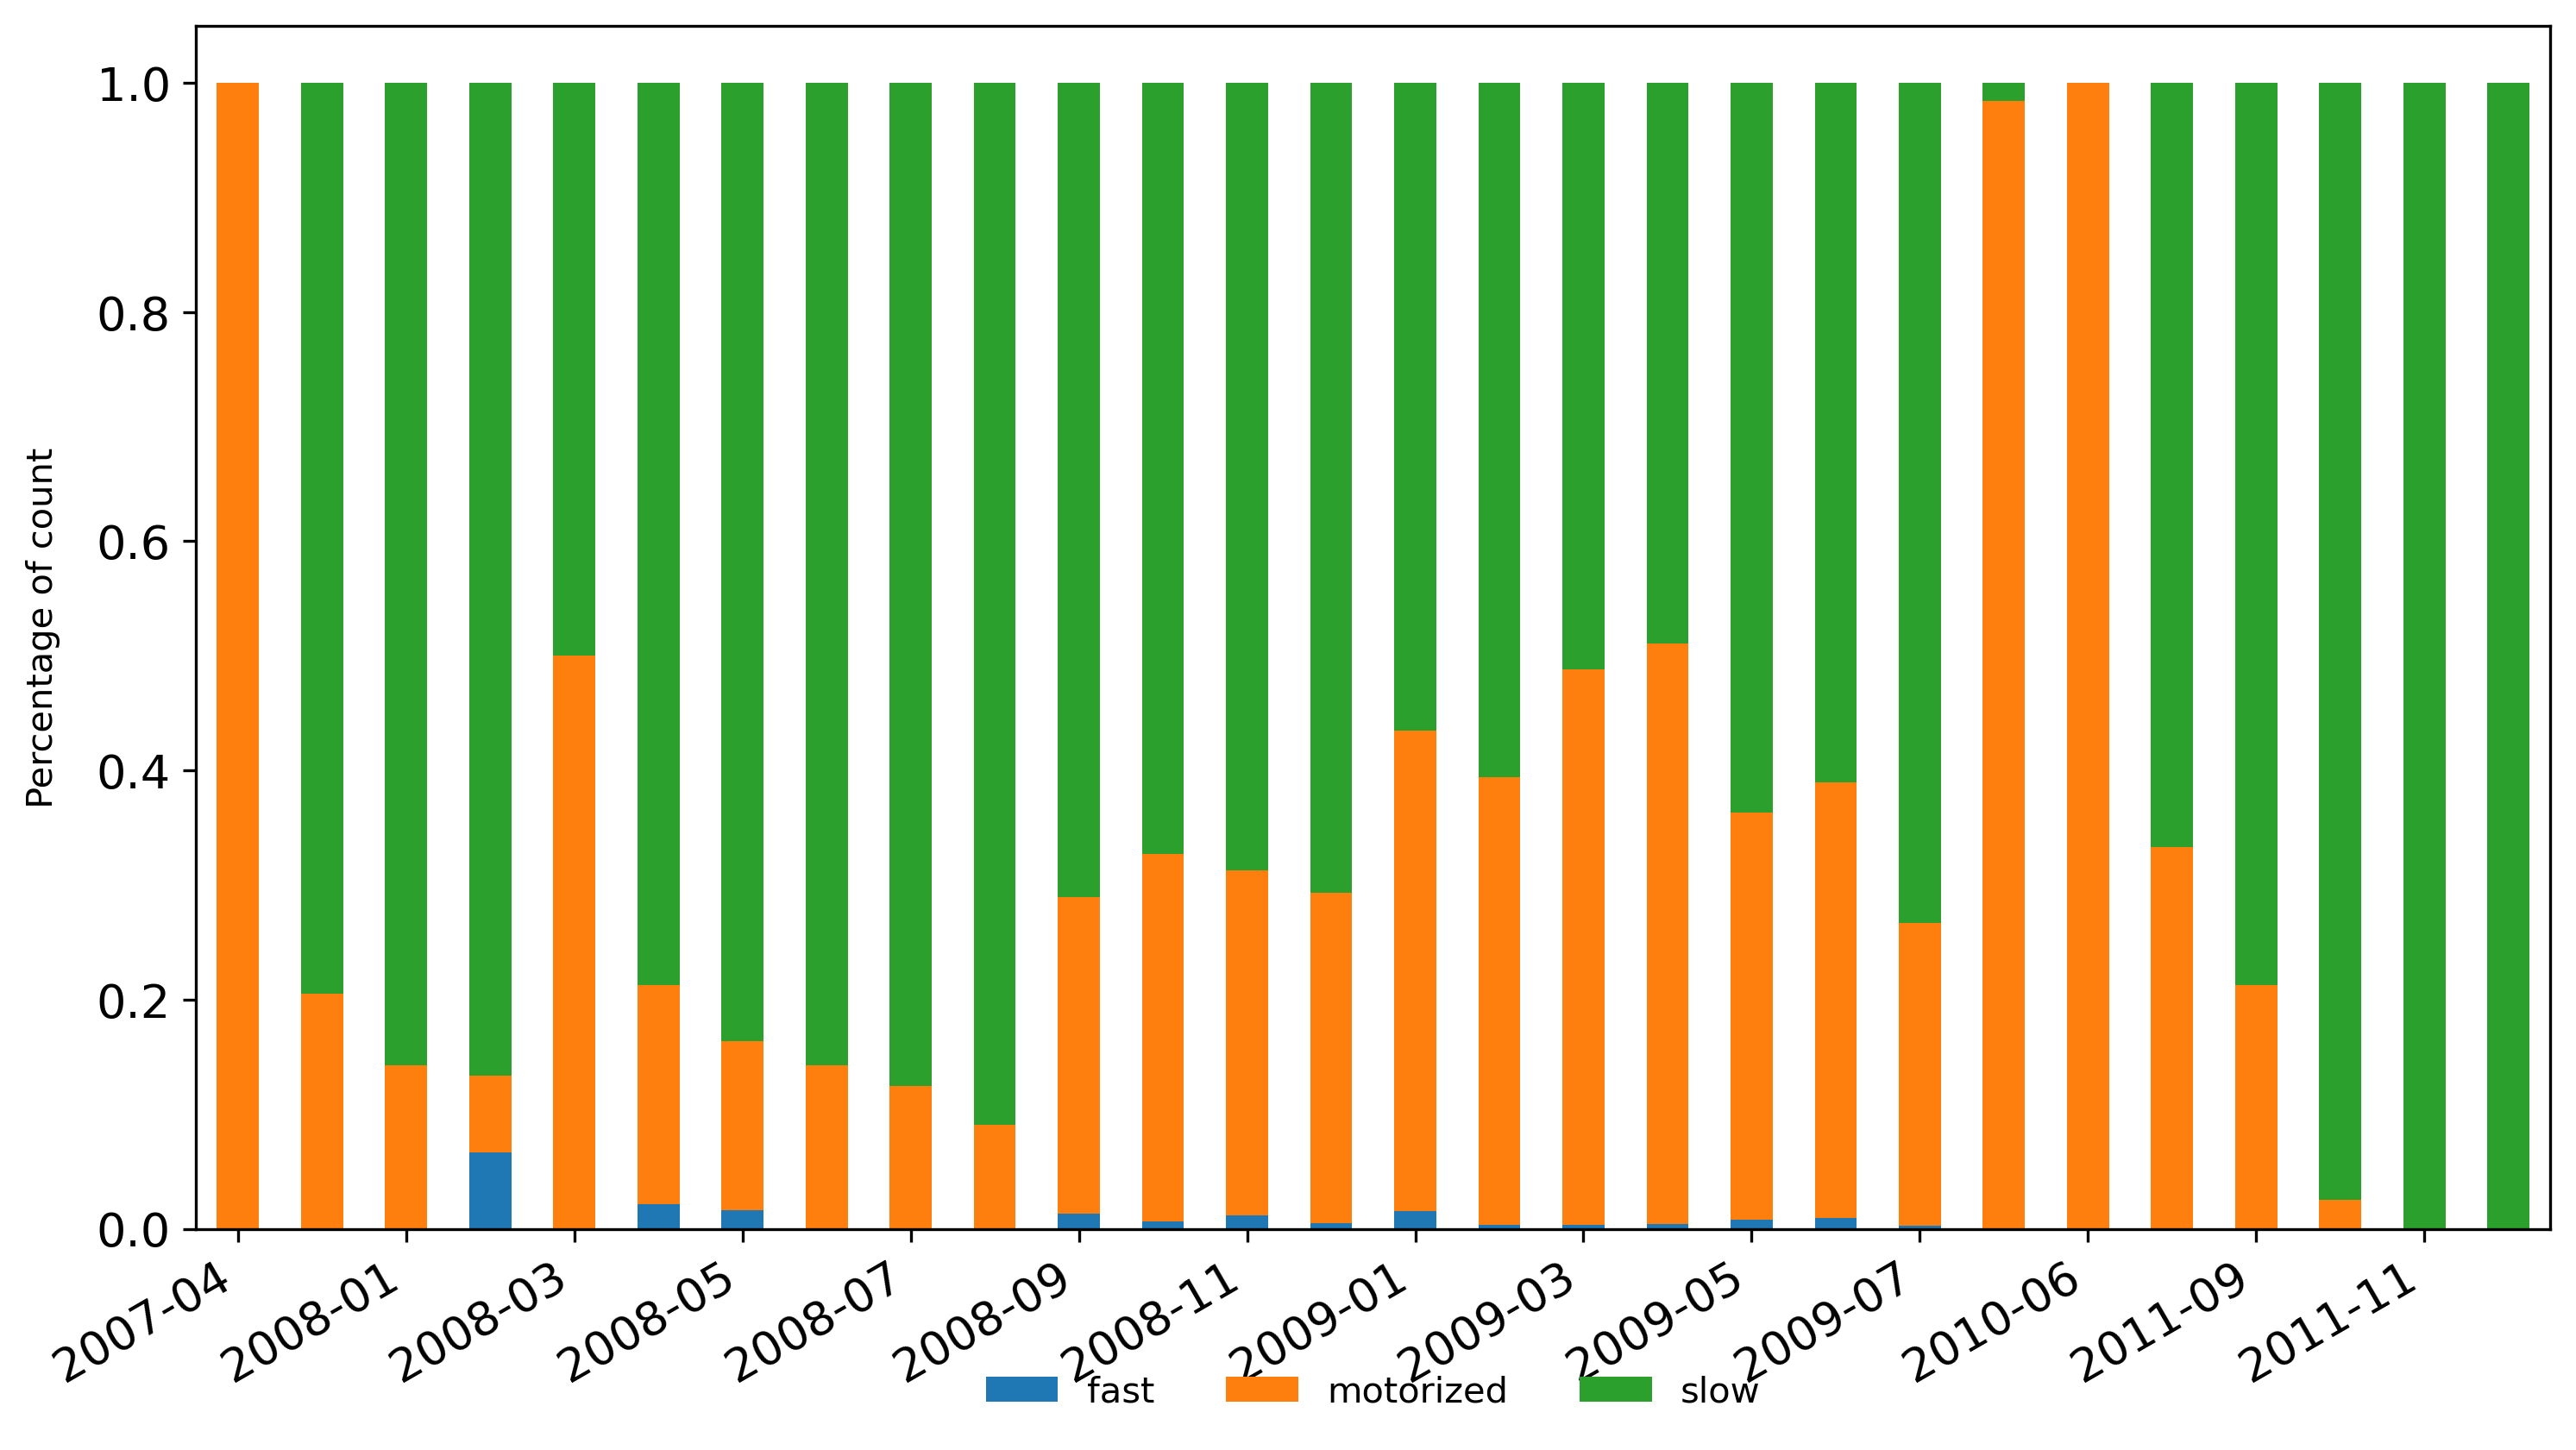

In [11]:
# count
modal_split_count = ti.analysis.calculate_modal_split(tpls, freq="M", metric="count", per_user=False, norm=True)

fig, ax = plt.subplots(figsize=(10, 6))
ax = ti.plot_modal_split(
    modal_split_count,
    date_fmt_x_axis="%Y-%m",
    y_label="Percentage of count",
    skip_xticks=2,
    n_col_legend=4,
    fig=fig,
    axis=ax,
    borderaxespad=2,
)
fig.autofmt_xdate()

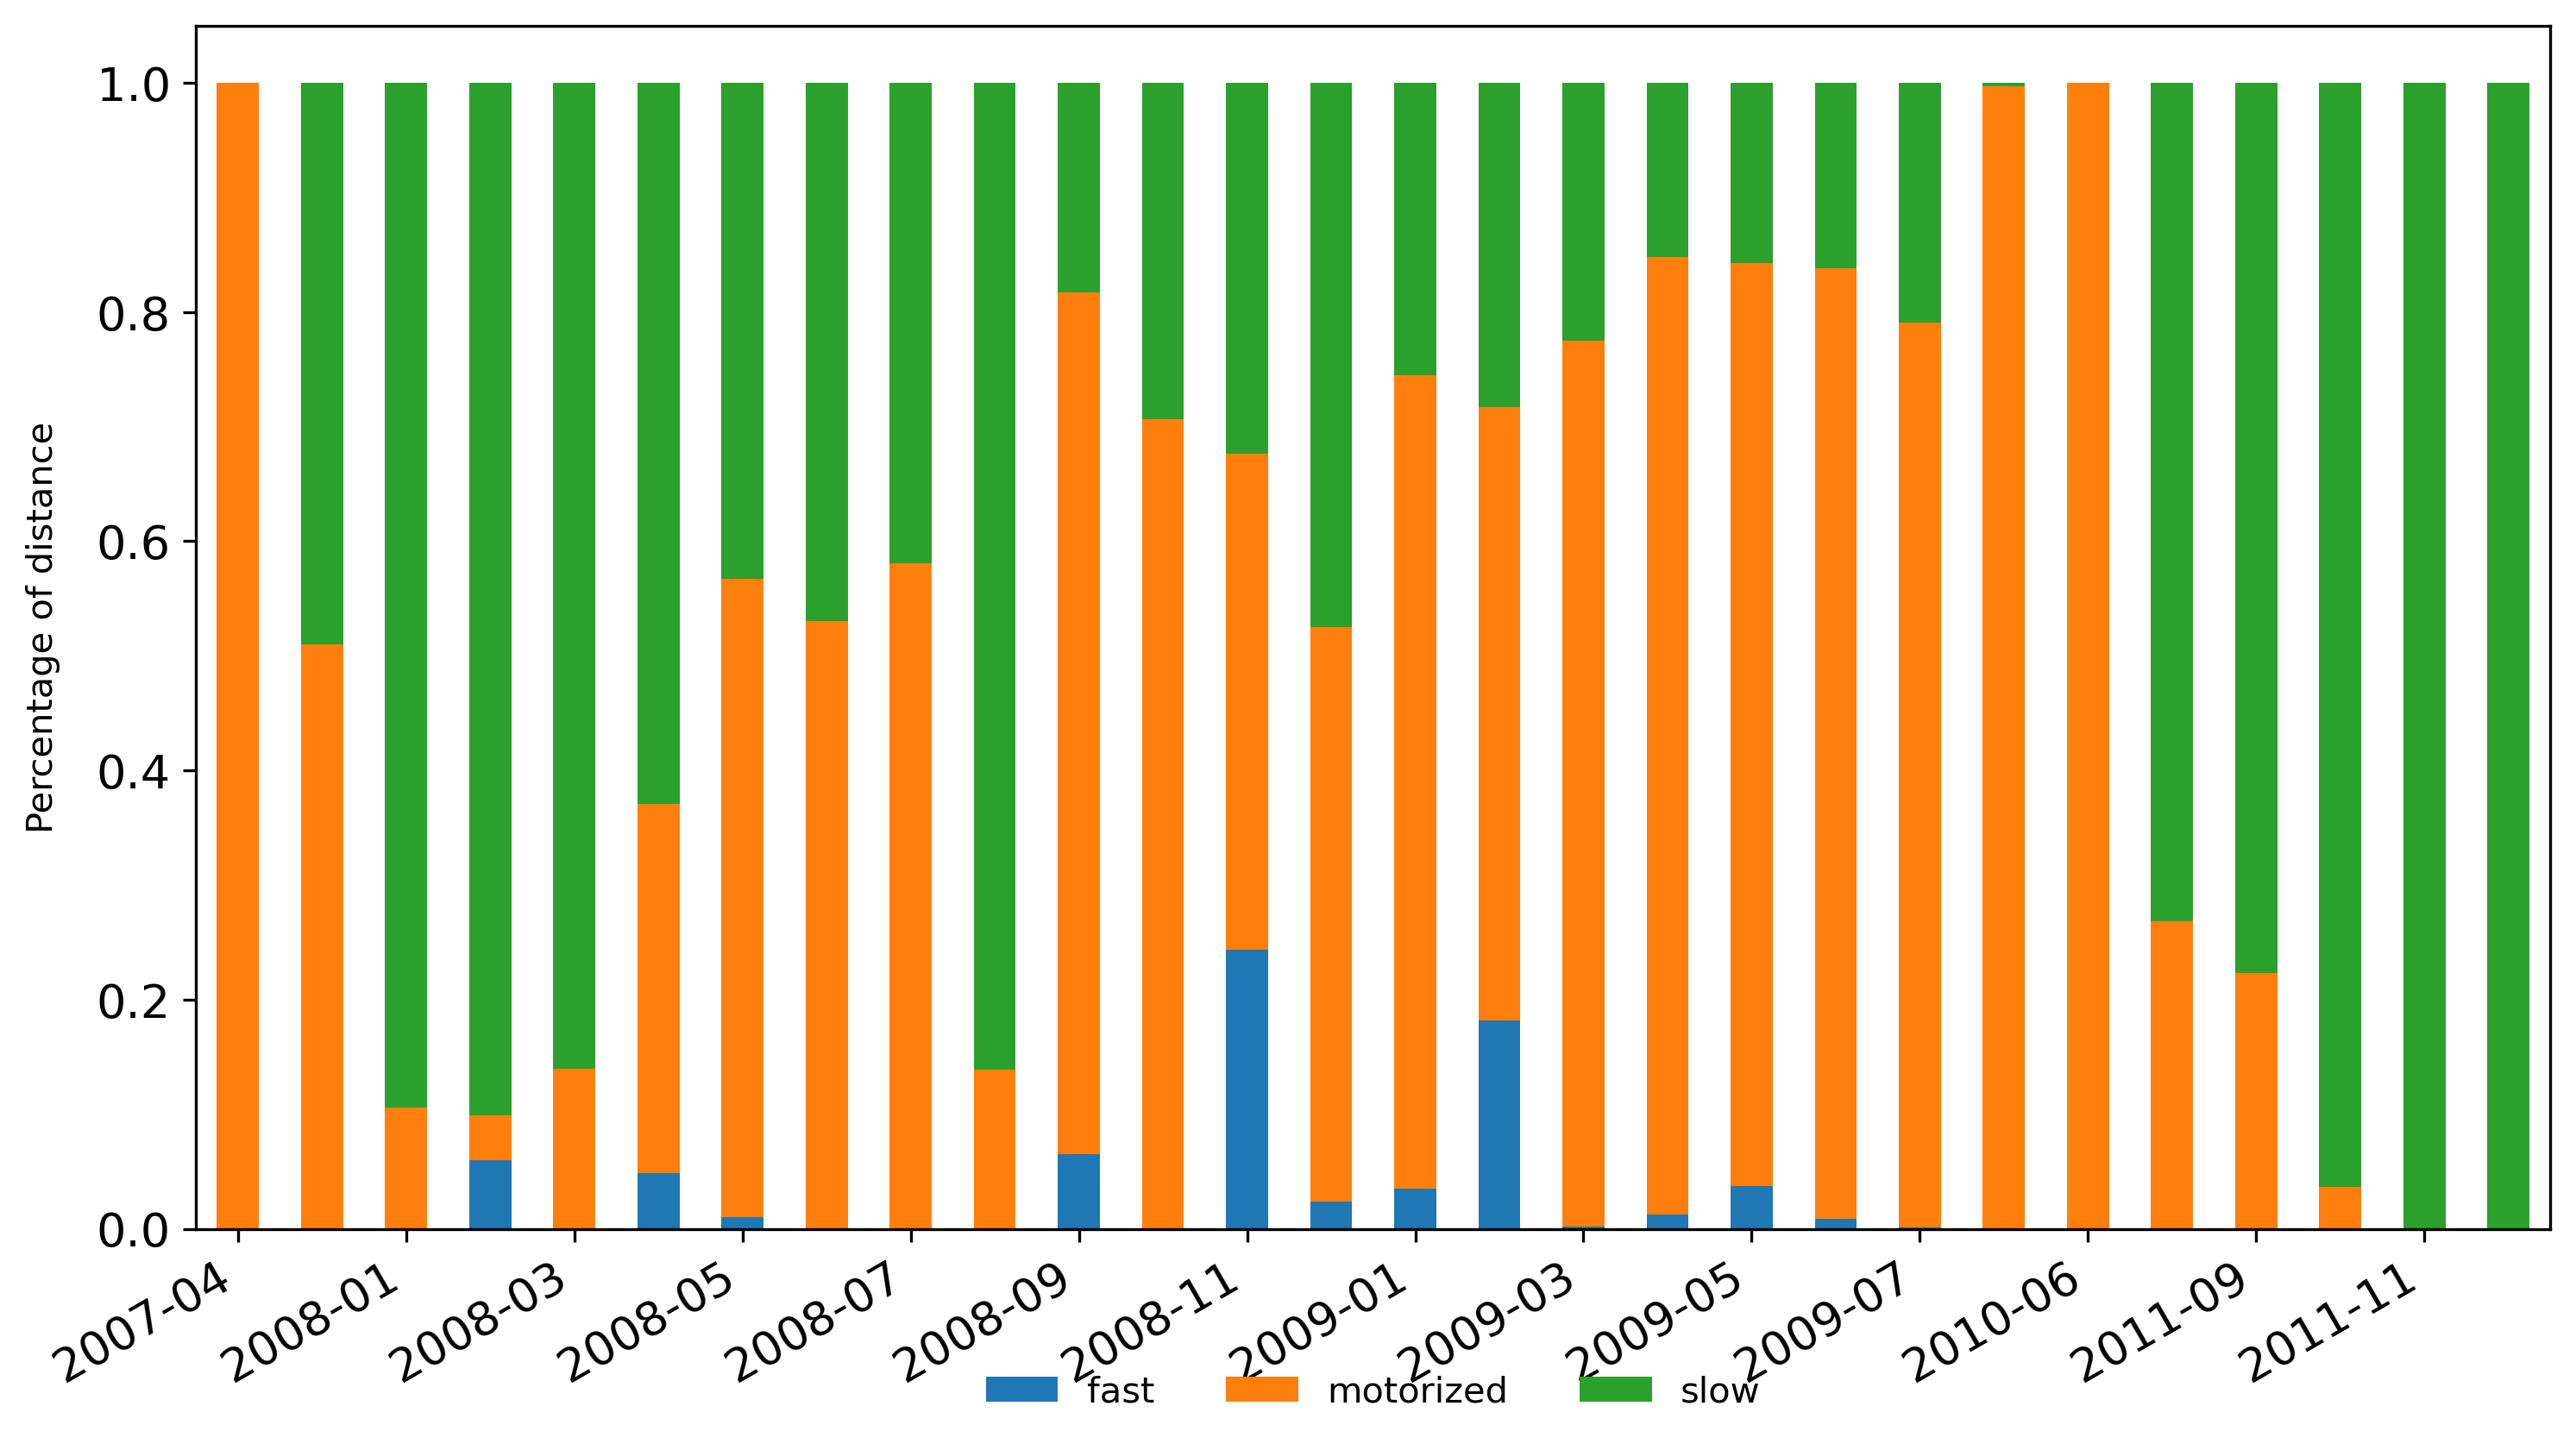

In [12]:
# distance
modal_split_distance = ti.analysis.calculate_modal_split(tpls, freq="M", metric="distance", per_user=False, norm=True)

fig, ax = plt.subplots(figsize=(10, 6))
ax = ti.plot_modal_split(
    modal_split_distance,
    date_fmt_x_axis="%Y-%m",
    y_label="Percentage of distance",
    skip_xticks=2,
    n_col_legend=4,
    fig=fig,
    axis=ax,
    borderaxespad=2,
)
fig.autofmt_xdate()

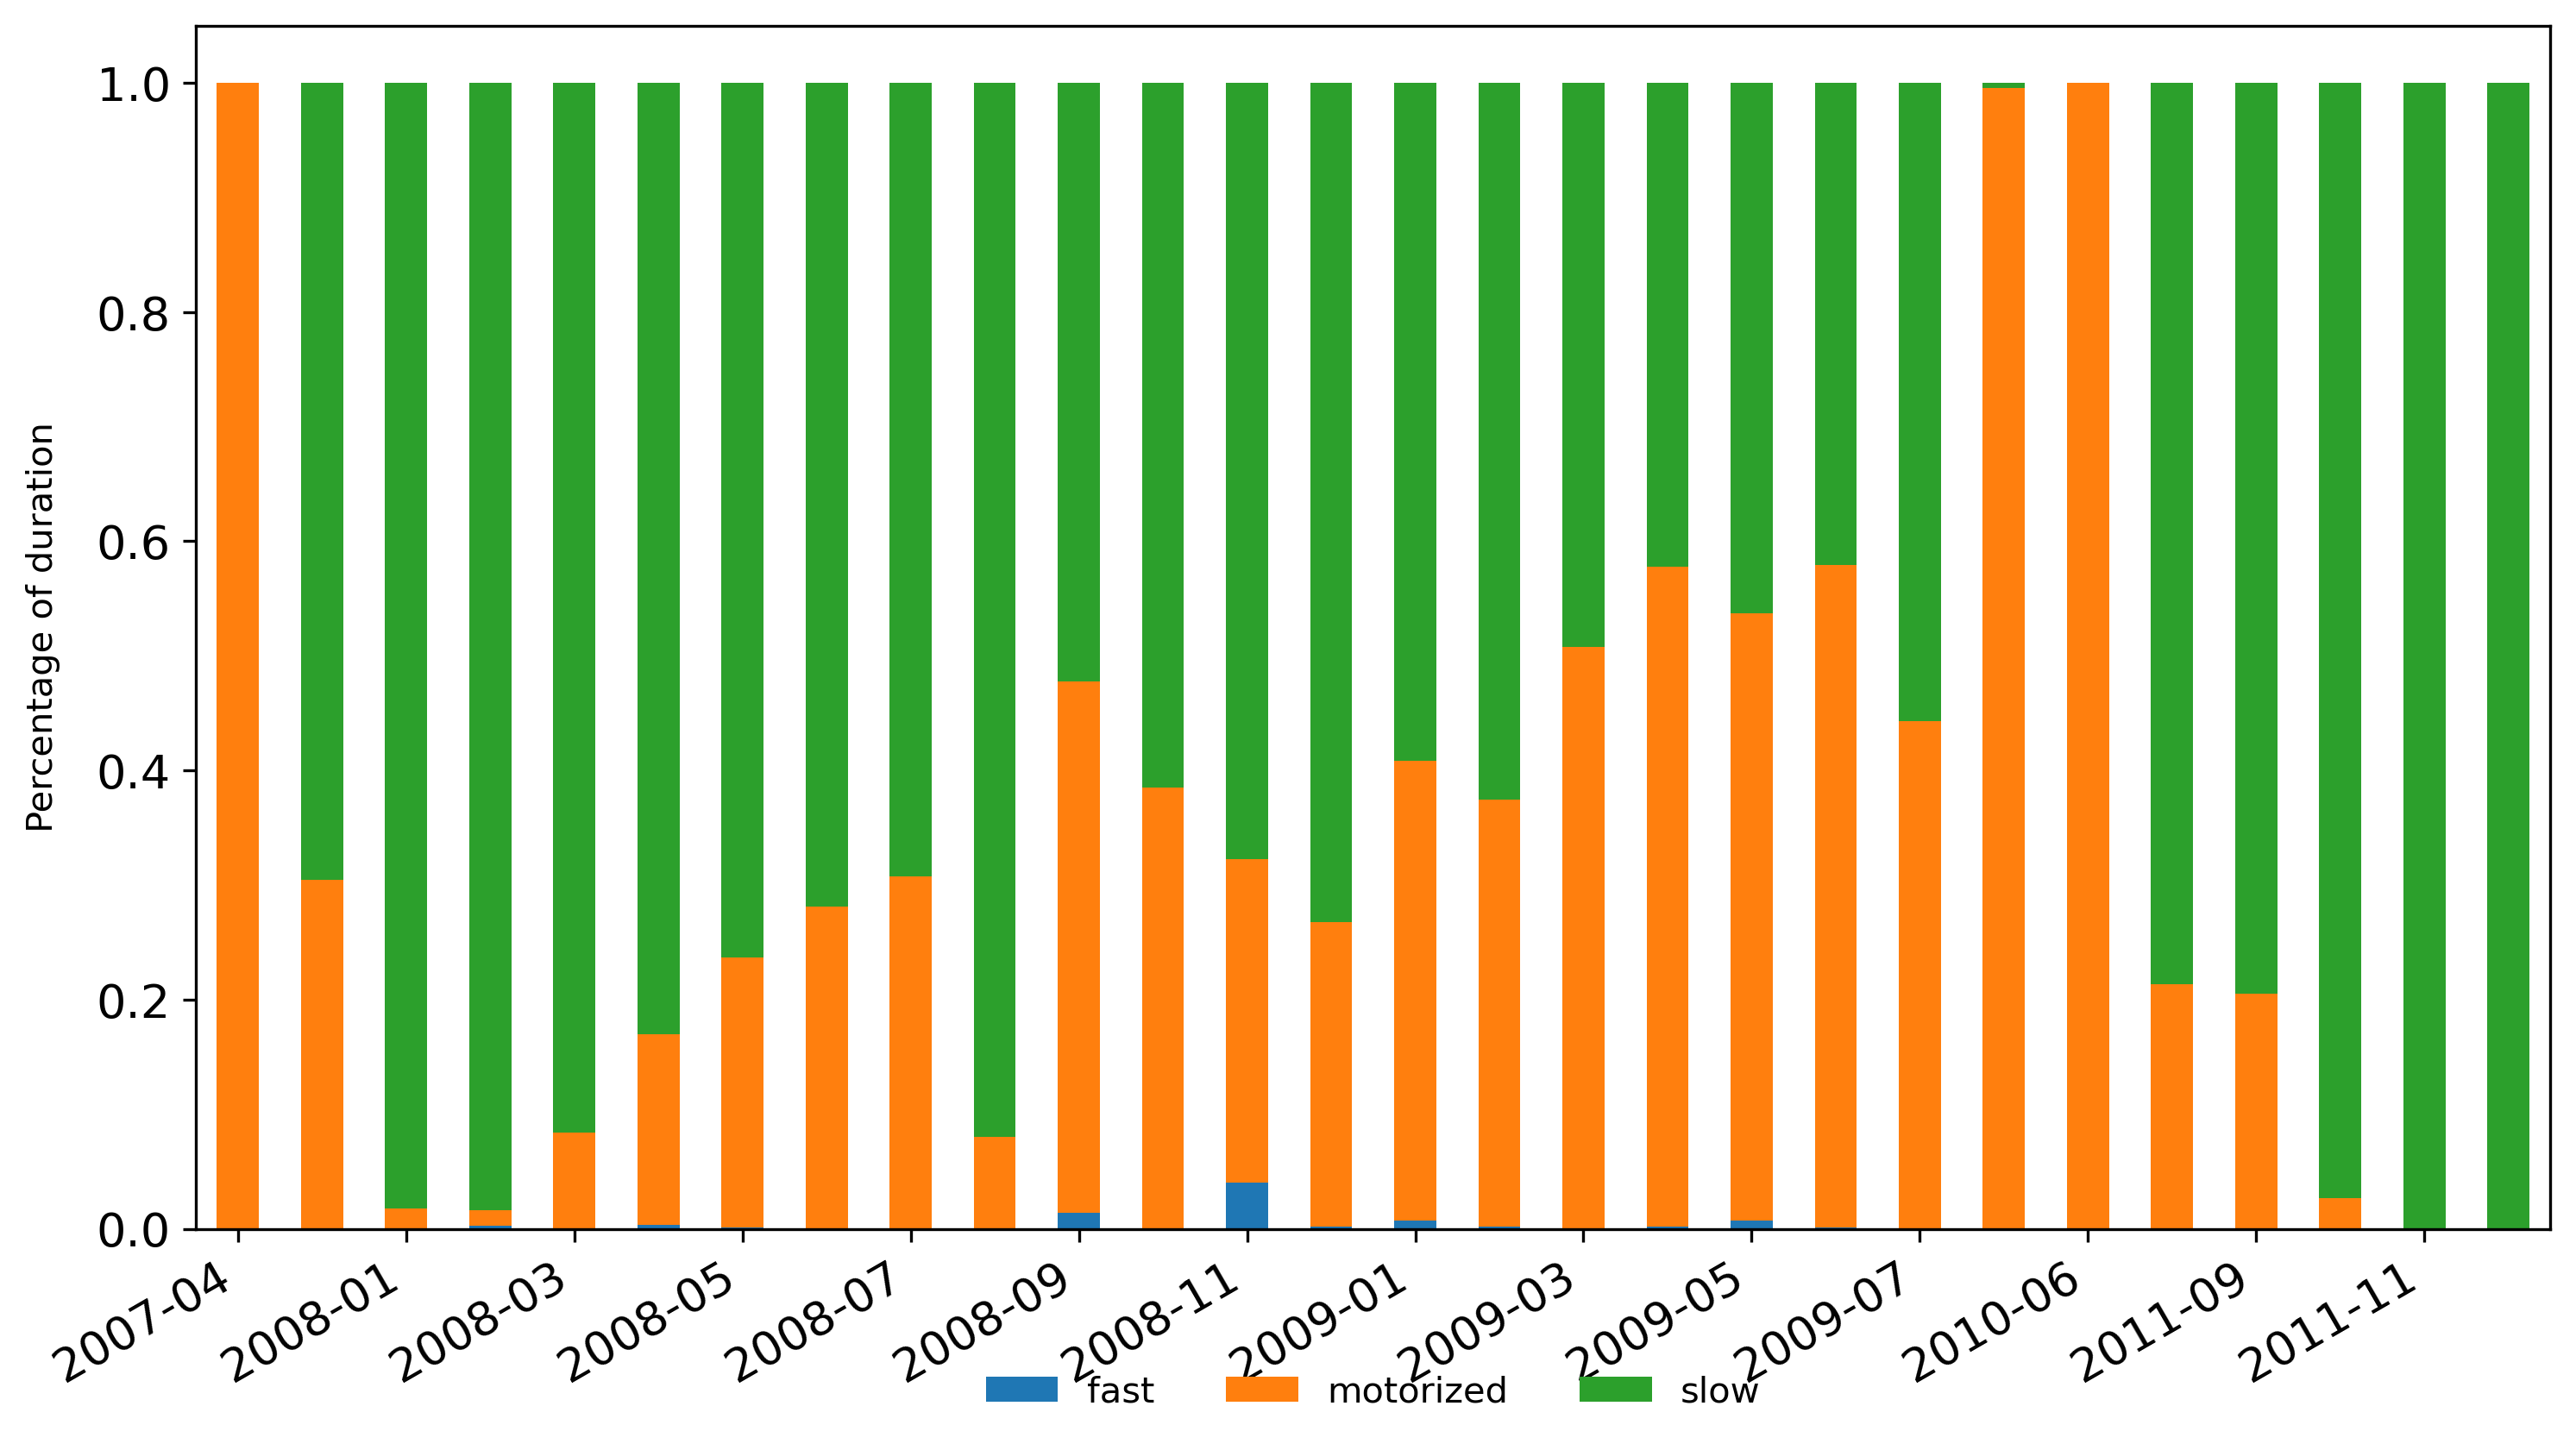

In [13]:
# duration
modal_split_duration = ti.analysis.calculate_modal_split(tpls, freq="M", metric="duration", per_user=False, norm=True)

fig, ax = plt.subplots(figsize=(10, 6))
ax = ti.plot_modal_split(
    modal_split_duration,
    date_fmt_x_axis="%Y-%m",
    y_label="Percentage of duration",
    skip_xticks=2,
    n_col_legend=4,
    fig=fig,
    axis=ax,
    borderaxespad=2,
)
fig.autofmt_xdate()

# 3. Calculate Jump length
## Read files

In [6]:
selected_pfs = ti.read_positionfixes_csv(os.path.join(save_dir, "selected_geolife_pfs.csv"), index_col="id", crs="EPSG:4326")

# validate
len(selected_pfs)

4396670

## Generate staypoints
Jump length measures the distance between consecutive stays. This definition corresponds to trackintel's **staypoint** data model. The following code is to generate staypoints from the raw positionfixes with the trackintel function [generate_staypoints](https://trackintel.readthedocs.io/en/latest/modules/preprocessing.html#trackintel.preprocessing.generate_staypoints). Click on the link to check the documentation on the meaning of the input parameters.

In [ ]:

pfs, sp = selected_pfs.generate_staypoints(gap_threshold=24 * 60, include_last=True, print_progress=True, dist_threshold=200, time_threshold=30, n_jobs=-1)

## Calculate jump length
Trackintel provide implementations for calculating the jumplength with staypoints that have geometry column. Check out the function [trackintel.analysis.metrics.jump_length()](https://trackintel.readthedocs.io/en/latest/modules/analysis.html#trackintel.analysis.jump_length). The output of the function is available as a series that shares the same index as the input dataframe. This ensures that we can use a column to hold the result (e.g., using `sp["jumplength"]`).

In [ ]:
sp["jumplength"] = ti.analysis.jump_length(sp)
jumplength_arr = sp.dropna(subset=["jumplength"])["jumplength"].values

## Visualize with powerlaw library 

In [ ]:
plt.figure(figsize=(8, 5))


# fit power law
xmin = 100
fit = powerlaw.Fit(jumplength_arr[jumplength_arr>xmin], xmin=xmin)

# plotting
powerlaw.plot_pdf(jumplength_arr[jumplength_arr>xmin], label="count")
fit.power_law.plot_pdf(linestyle="--", label="powerlaw fit")
fit.truncated_power_law.plot_pdf(linestyle="--", label="truncated power law")
fit.lognormal.plot_pdf(linestyle="--", label="lognormal fit")

xlabel = "$\Delta r\,(m)$"
ylabel = "$P(\Delta r)$"

plt.legend(prop={"size": 13})
plt.xlabel(xlabel, fontsize=16)
plt.ylabel(ylabel, fontsize=16)

plt.show()

# 4. Calculate Radius of Gyration
## Read files

In [7]:
selected_pfs = ti.read_positionfixes_csv(os.path.join(save_dir, "selected_geolife_pfs.csv"), index_col="id", crs="EPSG:4326")

# validate
len(selected_pfs)

4396670

## Generate staypoints

In [19]:
pfs, sp = selected_pfs.generate_staypoints(gap_threshold=24 * 60, include_last=True, print_progress=True, dist_threshold=200, time_threshold=30, n_jobs=-1)

c:\ProgramData\Anaconda3\envs\reprotrack\lib\site-packages\trackintel\preprocessing\positionfixes.py:113: UserWarning: 1690 duplicates were dropped from your positionfixes. Dropping duplicates is recommended but can be prevented using the 'exclude_duplicate_pfs' flag.
  warnings.warn(warn_str)
100%|██████████| 20/20 [00:00<00:00, 65.32it/s]


## Calculate radius of gyration with trackintel functions

In [ ]:
rg_count = ti.analysis.radius_gyration(sp, method="count")

In [ ]:
sp["duration"] = (sp["finished_at"] - sp["started_at"])
rg_duration = ti.analysis.radius_gyration(sp, method="duration")

In [ ]:
rg_duration

## Visualize with powerlaw package

In [ ]:
plt.figure(figsize=(8, 5))


# fit power law
xmin = 100
fit = powerlaw.Fit(rg_duration, xmin=xmin)

# plotting
powerlaw.plot_pdf(rg_count, label="count")
powerlaw.plot_pdf(rg_duration, label="duration")
fit.power_law.plot_pdf(linestyle="--", label="powerlaw fit of duration")
fit.truncated_power_law.plot_pdf(linestyle="--", label="truncated power law of duration")
fit.lognormal.plot_pdf(linestyle="--", label="lognormal fit of duration")

xlabel = "$Rg$ (m)"
ylabel = "$P(Rg)$"

plt.legend(prop={"size": 13})
plt.xlabel(xlabel, fontsize=16)
plt.ylabel(ylabel, fontsize=16)

plt.show()


# 5. Activity prediction - trajectory context integration with OSM data
## Read files

In [5]:
selected_pfs = ti.read_positionfixes_csv(os.path.join(save_dir, "selected_geolife_pfs.csv"), index_col="id")

## Generate staypoints and locations

In [6]:
# generate staypoints, triplegs and trips
pfs, sp = selected_pfs.generate_staypoints(gap_threshold=24 * 60, include_last=True, print_progress=True, dist_threshold=200, time_threshold=30, n_jobs=-1)

# create activity flag
sp = sp.create_activity_flag(method="time_threshold", time_threshold=25)

# generate locations
## filter activity staypoints
sp = sp.loc[sp["is_activity"] == True]

# generate locations
sp, locs = sp.generate_locations(
    epsilon=20, num_samples=1, distance_metric="haversine", agg_level="dataset", n_jobs=-1, print_progress=True
)
# filter noise staypoints
valid_sp = sp.loc[~sp["location_id"].isna()]

c:\ProgramData\Anaconda3\envs\reprotrack\lib\site-packages\trackintel\preprocessing\positionfixes.py:113: UserWarning: 1690 duplicates were dropped from your positionfixes. Dropping duplicates is recommended but can be prevented using the 'exclude_duplicate_pfs' flag.
  warnings.warn(warn_str)
100%|██████████| 20/20 [00:00<00:00, 35.81it/s]
c:\ProgramData\Anaconda3\envs\reprotrack\lib\site-packages\trackintel\geogr\distances.py:298: UserWarning: The CRS of your data is not defined.
  warnings.warn("The CRS of your data is not defined.")


In [7]:
# examine locations
locs.head(5)

user_id                      center  \
id                                        
0         1  POINT (116.32724 39.97809)   
1         1  POINT (116.30644 40.01385)   
2         1  POINT (116.32601 39.97863)   
3         1  POINT (116.30986 39.98129)   
4         1  POINT (116.30927 39.98149)   

                                               extent  
id                                                     
0   POLYGON ((116.32763 39.97692, 116.32751 39.977...  
1   POLYGON ((116.30689 40.01356, 116.30669 40.013...  
2   POLYGON ((116.32581 39.97849, 116.32575 39.978...  
3   POLYGON ((116.31010 39.98129, 116.31010 39.981...  
4   POLYGON ((116.30951 39.98149, 116.30950 39.981...

## Extract POI from OSM and link with locations

You can imagine that we can make certain statements about the reason for a trip if we know what is in the area at the destination. For example, it makes sense that we go to a university district to study, to a residential area when we go home, or to an area with many restaurants and bars to meet friends.

### POI from OSM

Following this intuition, we extract POIs from OpenStreetMap and link them spatially with the locations. First we define a filter, defining that OSM objects with the attribute `amenity` or `shop` are extracted from the OSM data set. These tags are very widespread in the OSM data because they describe various objects in a relatively general way. You can find out more about the OSM tags at https://wiki.openstreetmap.org/wiki/DE:Key:amenity and https://taginfo.openstreetmap.org.

We use the library `osmnx` to download the newest osm data from the internet and extract certain subsets of the data as GeoDataFrame. `osmnx` is an open-source library that provides support for working with OpenStreetMap data. It enables straightforward fetching of OSM data and is still actively maintained by a group of GIS enthusiasts. Checkout the library [homepage](https://osmnx.readthedocs.io/en/stable/getting-started.html) and its [examples](https://github.com/gboeing/osmnx-examples/tree/main/notebooks).

Here we define the filter below for the POIs for you.

In [8]:
custom_filter = {'amenity': True, 'shop': True}

# apply the filter
pois = ox.features_from_bbox(40.0920, 39.8594, 116.4410, 116.1152, custom_filter)

# we now want the 'node' types
pois = pois.iloc[pois.index.get_level_values('element_type') == "node"]

pois.shape

(7783, 344)

Use the function `plot`, which is provided by the `geopandas` library for `GeoDataFrames`.

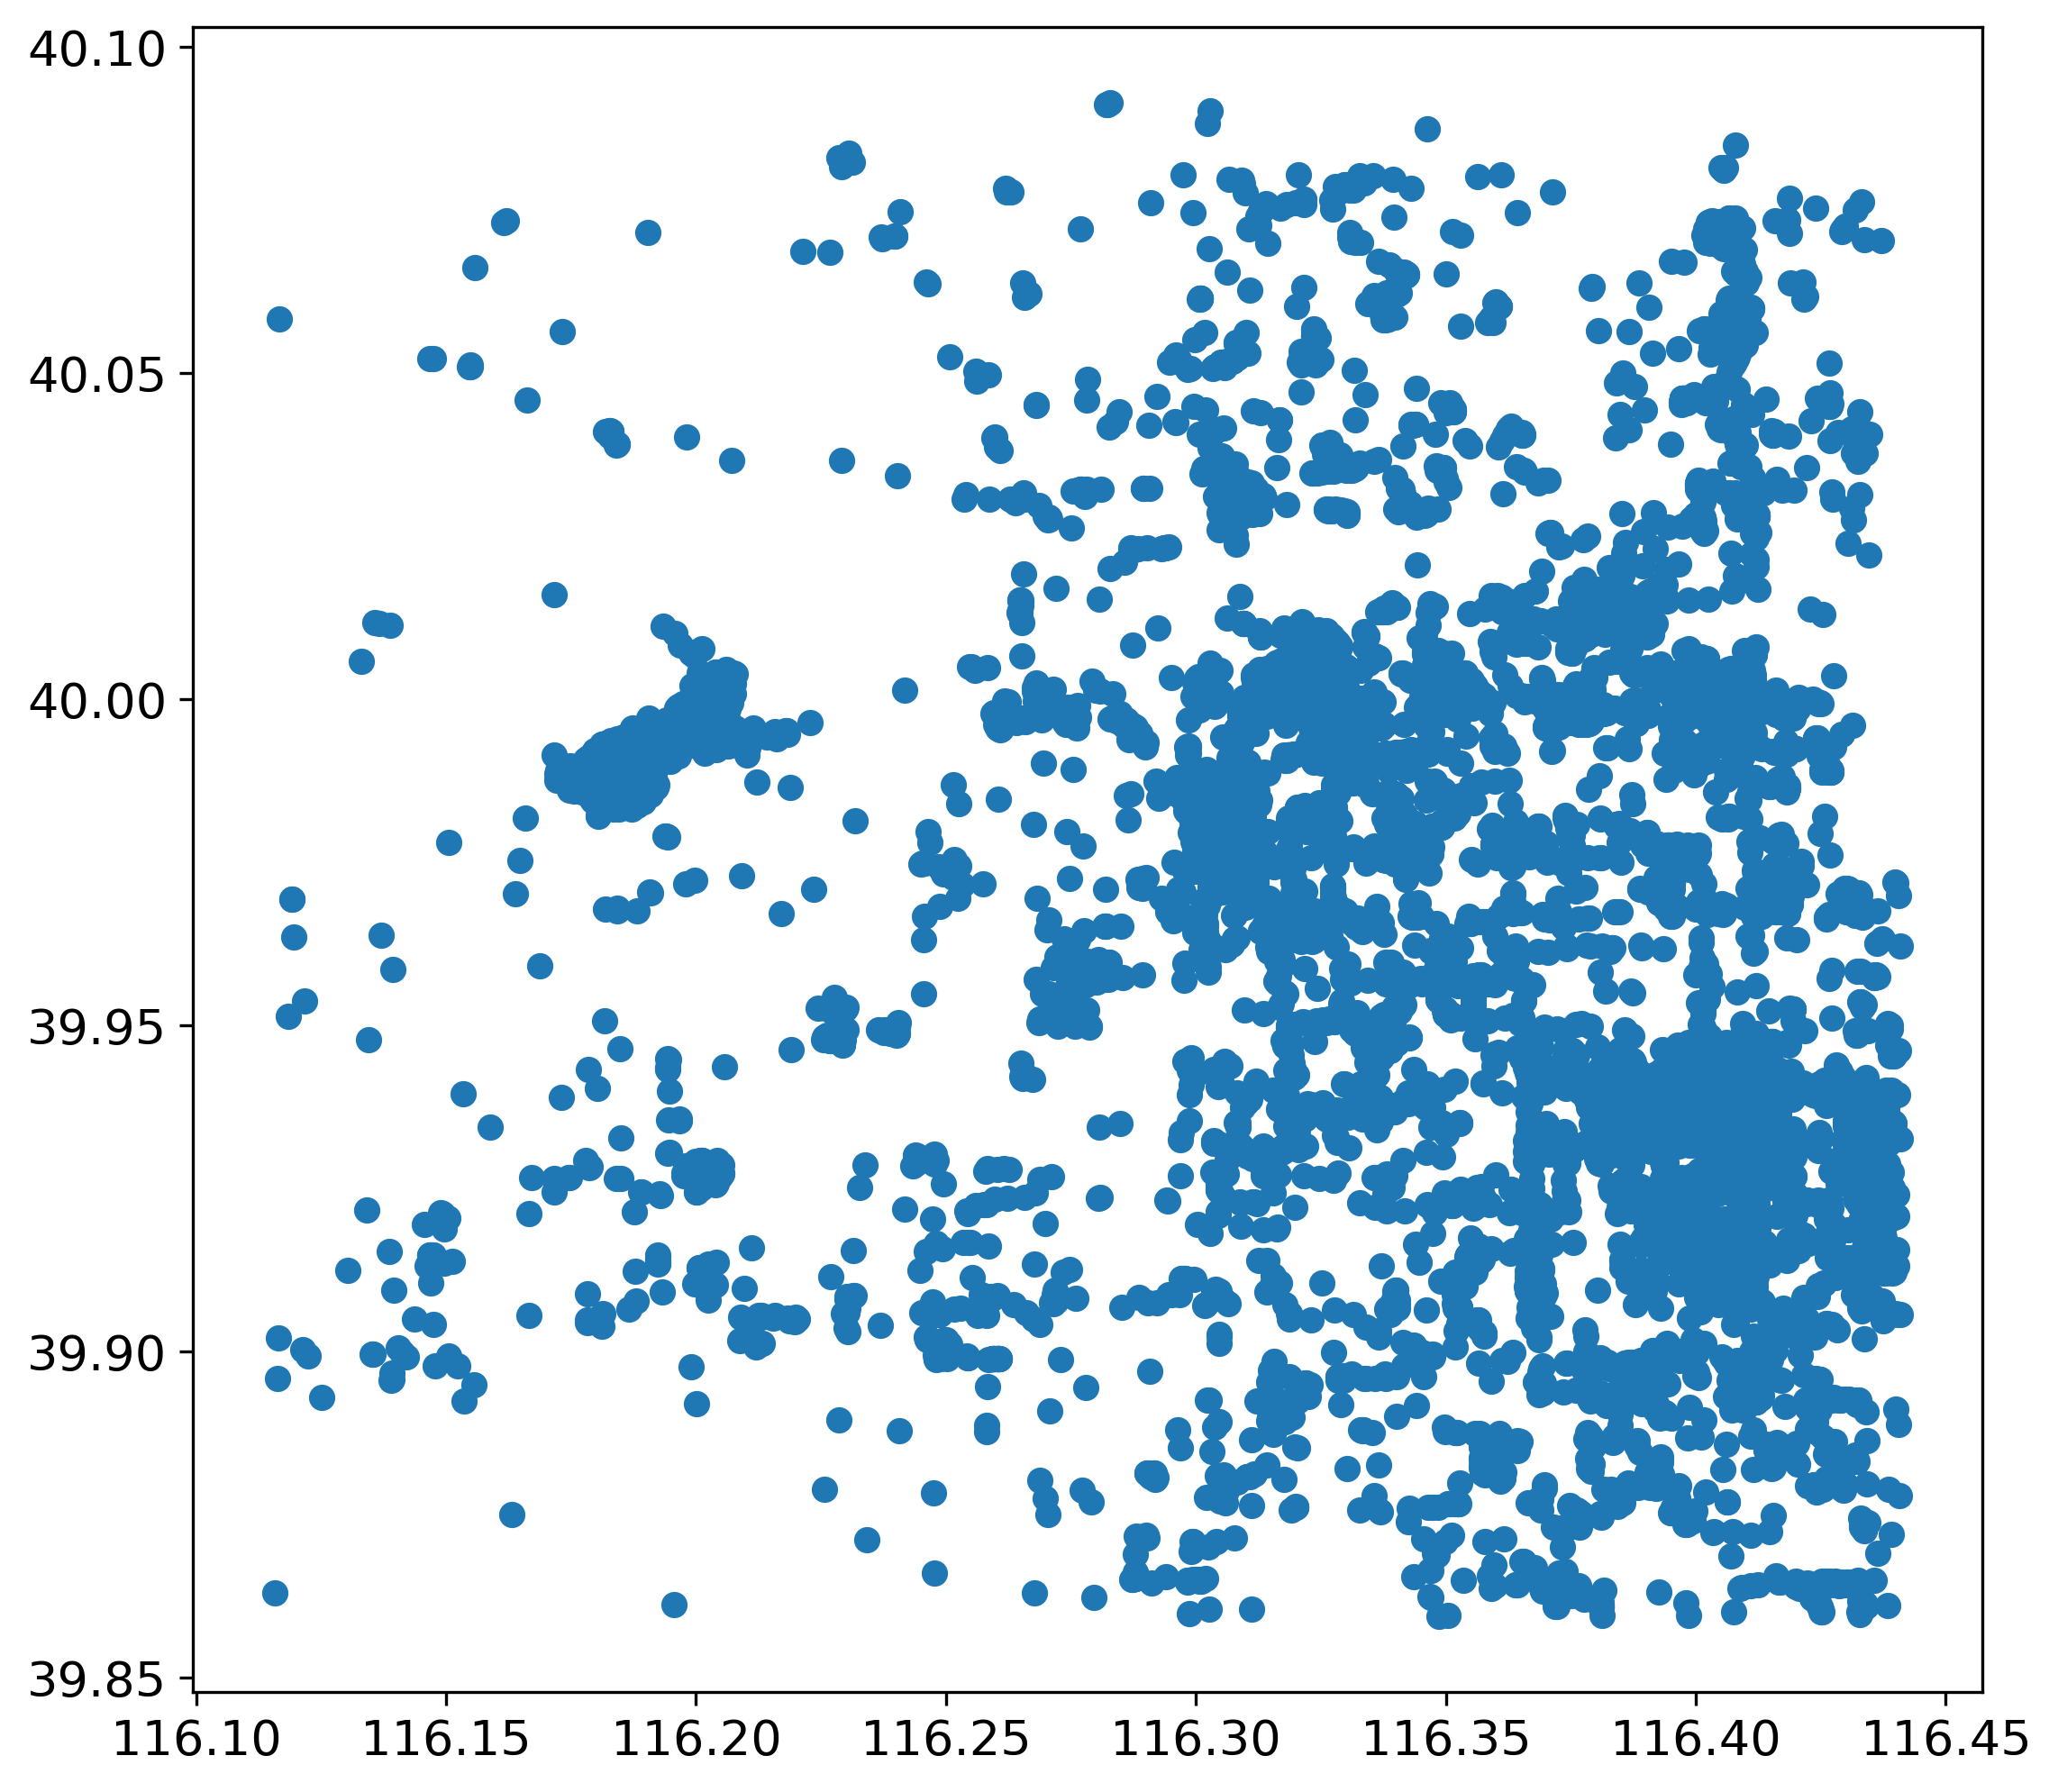

In [9]:
pois.plot(figsize=(12, 8))
plt.show()

We can now display this data on a map and inspect it again with `.head (...)`.

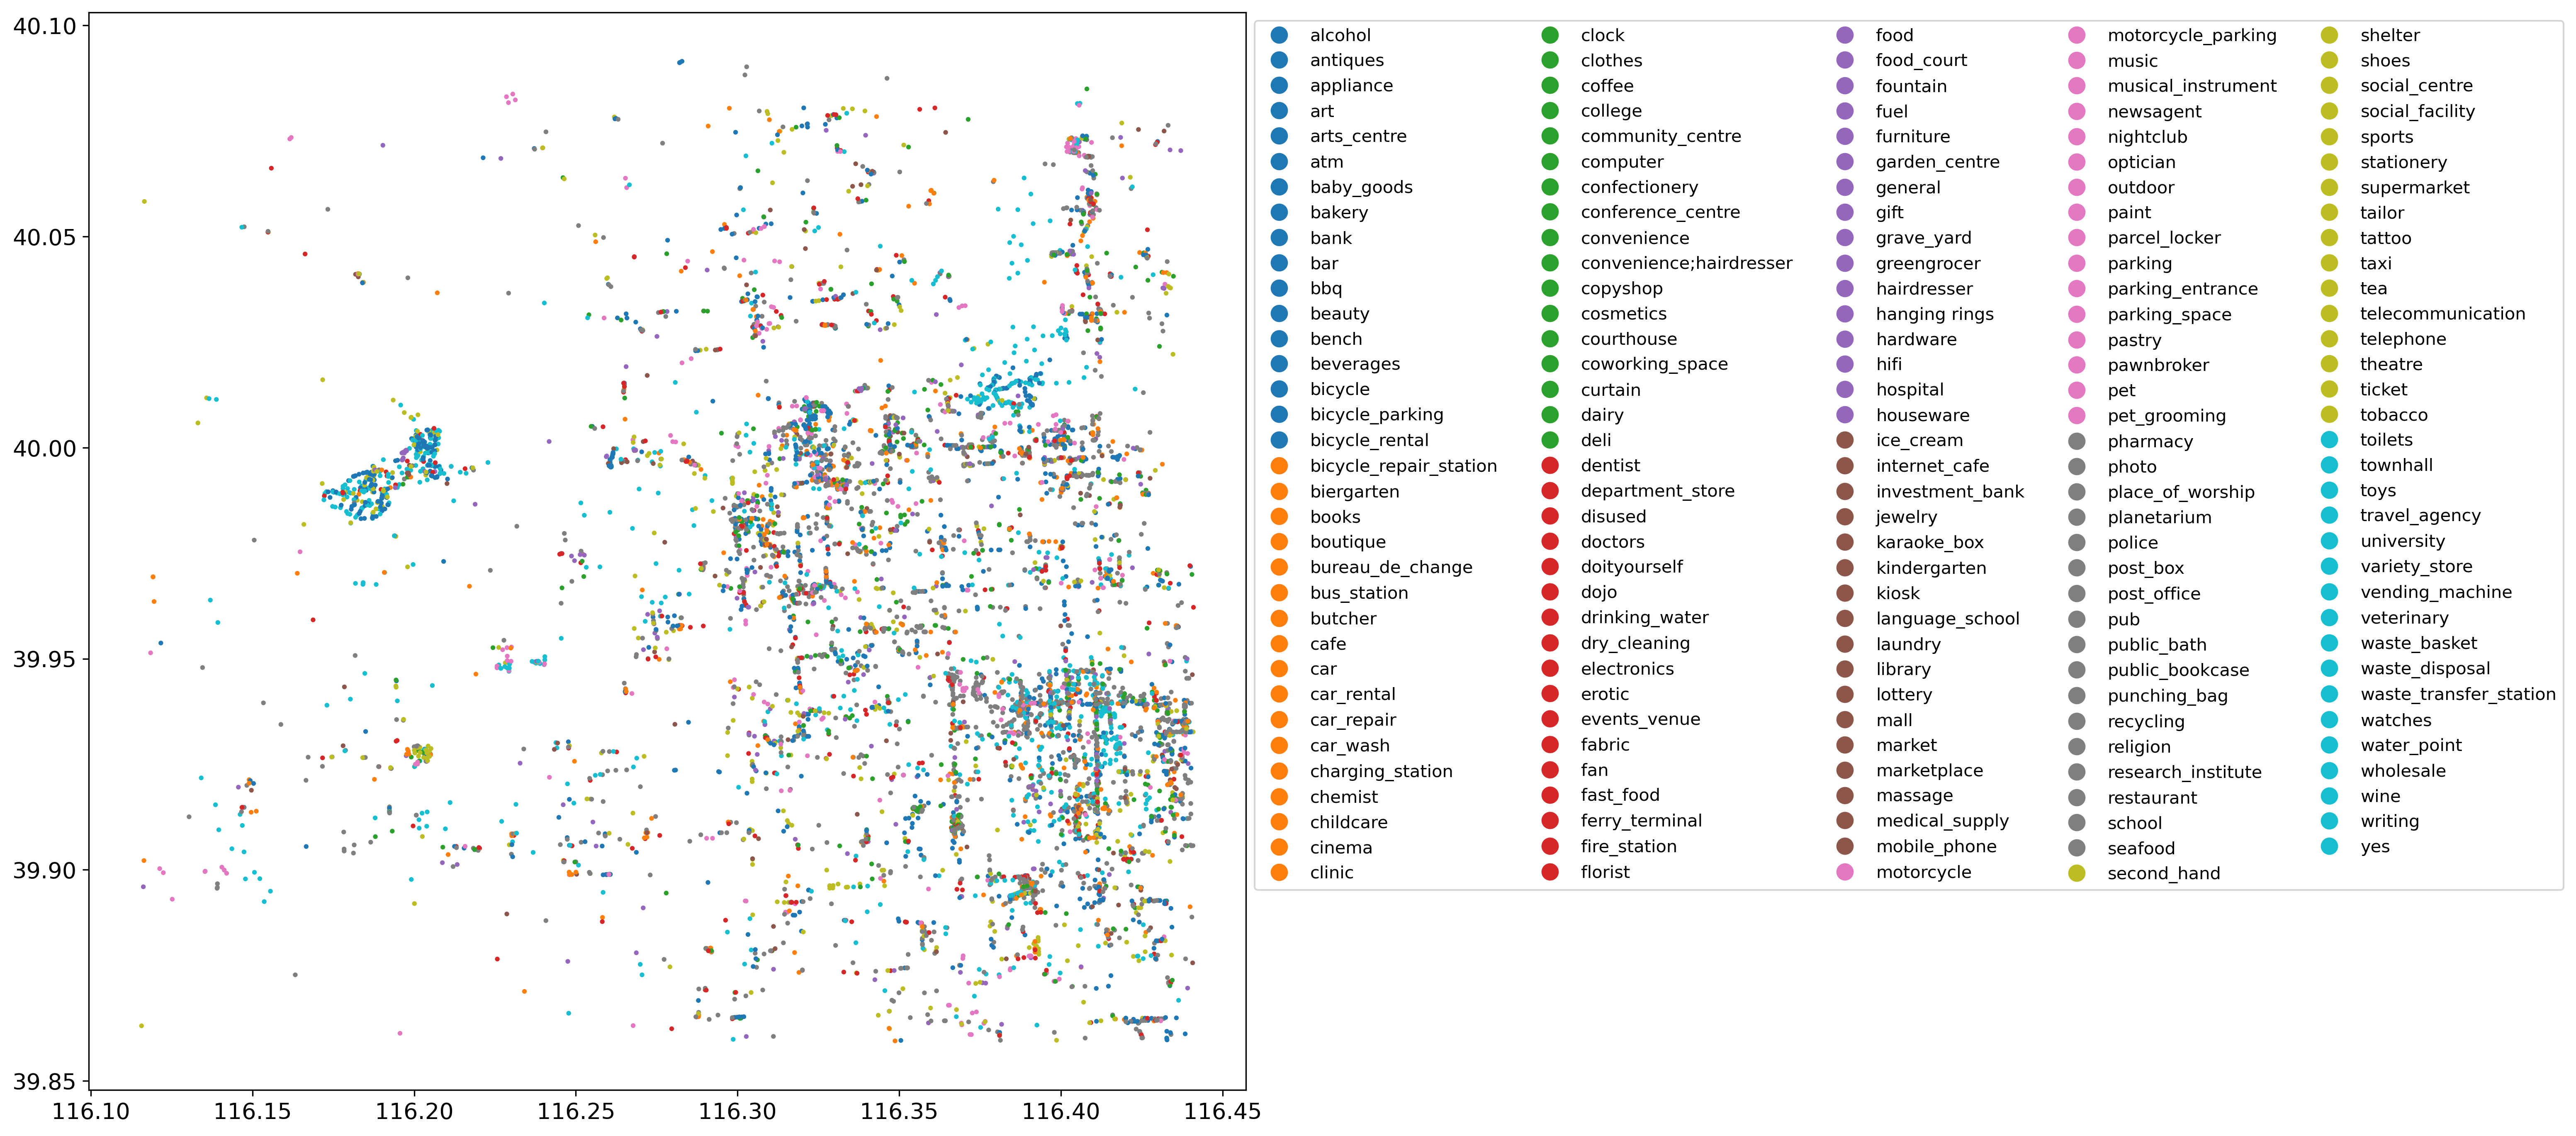

In [10]:
# Gather info about POI type (combines the tag info from "amenity" and "shop").
pois["poi_type"] = pois["amenity"]
pois["poi_type"] = pois["poi_type"].fillna(pois["shop"])

# plot
ax = pois.plot(column='poi_type', markersize=3, figsize=(12,12), legend=True, legend_kwds=dict(loc='upper left', ncol=5, bbox_to_anchor=(1, 1)))
plt.show()

In [11]:
# Inspect the DataFrame using .head(...), .columns, etc.
pois.columns

Index(['amenity', 'check_date', 'fee', 'geometry', 'ferry', 'public_transport',
       'name', 'name:en', 'name:zh_pinyin', 'religion',
       ...
       'name:nan', 'name:nan-HJ', 'name:nan-POJ', 'name:nan-TL', 'name:hi',
       'name:no', 'name:pt', 'name:uk', 'name:ja_kana', 'poi_type'],
      dtype='object', length=345)

### Conversion to projected coordinate system, buffering and spatial join

In the next step, we want to change the coordinate system from WGS 1984 to EPSG:4479, as the latter allows us to quantify distances in meters. `geopandas` offers the function `.to_crs(...)` for this operation. Then create a buffer around the sample points with the function `.buffer(dist)` and use the `gpd.sjoin(...)` function to perform a spatial join between the buffered sample points and the POI. Look at the data with `.head(...)` and check if the results make sense.

In [12]:
# Create buffer around locations. assume distance of 100
epsilon = 100


# project the data into the coordinate system EPSG:4479.
locs_4479 = gpd.GeoDataFrame(locs.drop(columns="center"), crs="EPSG:4326", geometry="extent")
locs_4479 = locs_4479.to_crs('EPSG:4479')
pois_4479 = pois.to_crs('EPSG:4479')

locs_buffer = locs_4479.copy()

# Create a buffer of reasonable size around the locations.
# Remember to set a distance threshold in .buffer() (now the unit is in meters)
locs_buffer['extent'] = locs_4479.buffer(epsilon)


# Join the two GeoDataFrames using geopanda's sjoin function (use how='left').
locs_pois = gpd.sjoin(locs_buffer, pois_4479, how='left')
locs_pois = locs_pois.reset_index()


In [13]:
# examine locations
locs_pois.head(3)

id  user_id                                             extent  \
0   0        1  POLYGON ((-2170750.86992 4386628.92660, -21707...   
1   0        1  POLYGON ((-2170750.86992 4386628.92660, -21707...   
2   0        1  POLYGON ((-2170750.86992 4386628.92660, -21707...   

  index_right0  index_right1     amenity check_date  fee ferry  \
0         node  4.860839e+09  restaurant        NaN  NaN   NaN   
1         node  3.951207e+09        bank        NaN  NaN   NaN   
2         node  6.050499e+09   fast_food        NaN  NaN   NaN   

  public_transport  ... name:nan name:nan-HJ name:nan-POJ name:nan-TL name:hi  \
0              NaN  ...      NaN         NaN          NaN         NaN     NaN   
1              NaN  ...      NaN         NaN          NaN         NaN     NaN   
2              NaN  ...      NaN         NaN          NaN         NaN     NaN   

  name:no name:pt name:uk name:ja_kana    poi_type  
0     NaN     NaN     NaN          NaN  restaurant  
1     NaN     NaN     NaN          NaN        bank  
2     NaN     NaN     NaN          NaN   fast_food  

[3 rows x 349 columns]

We can now count how often a certain type of POI has occurred in the vicinity of a location and draw this in a figure. Attention: We only plot the first 20 locations for simplicity.

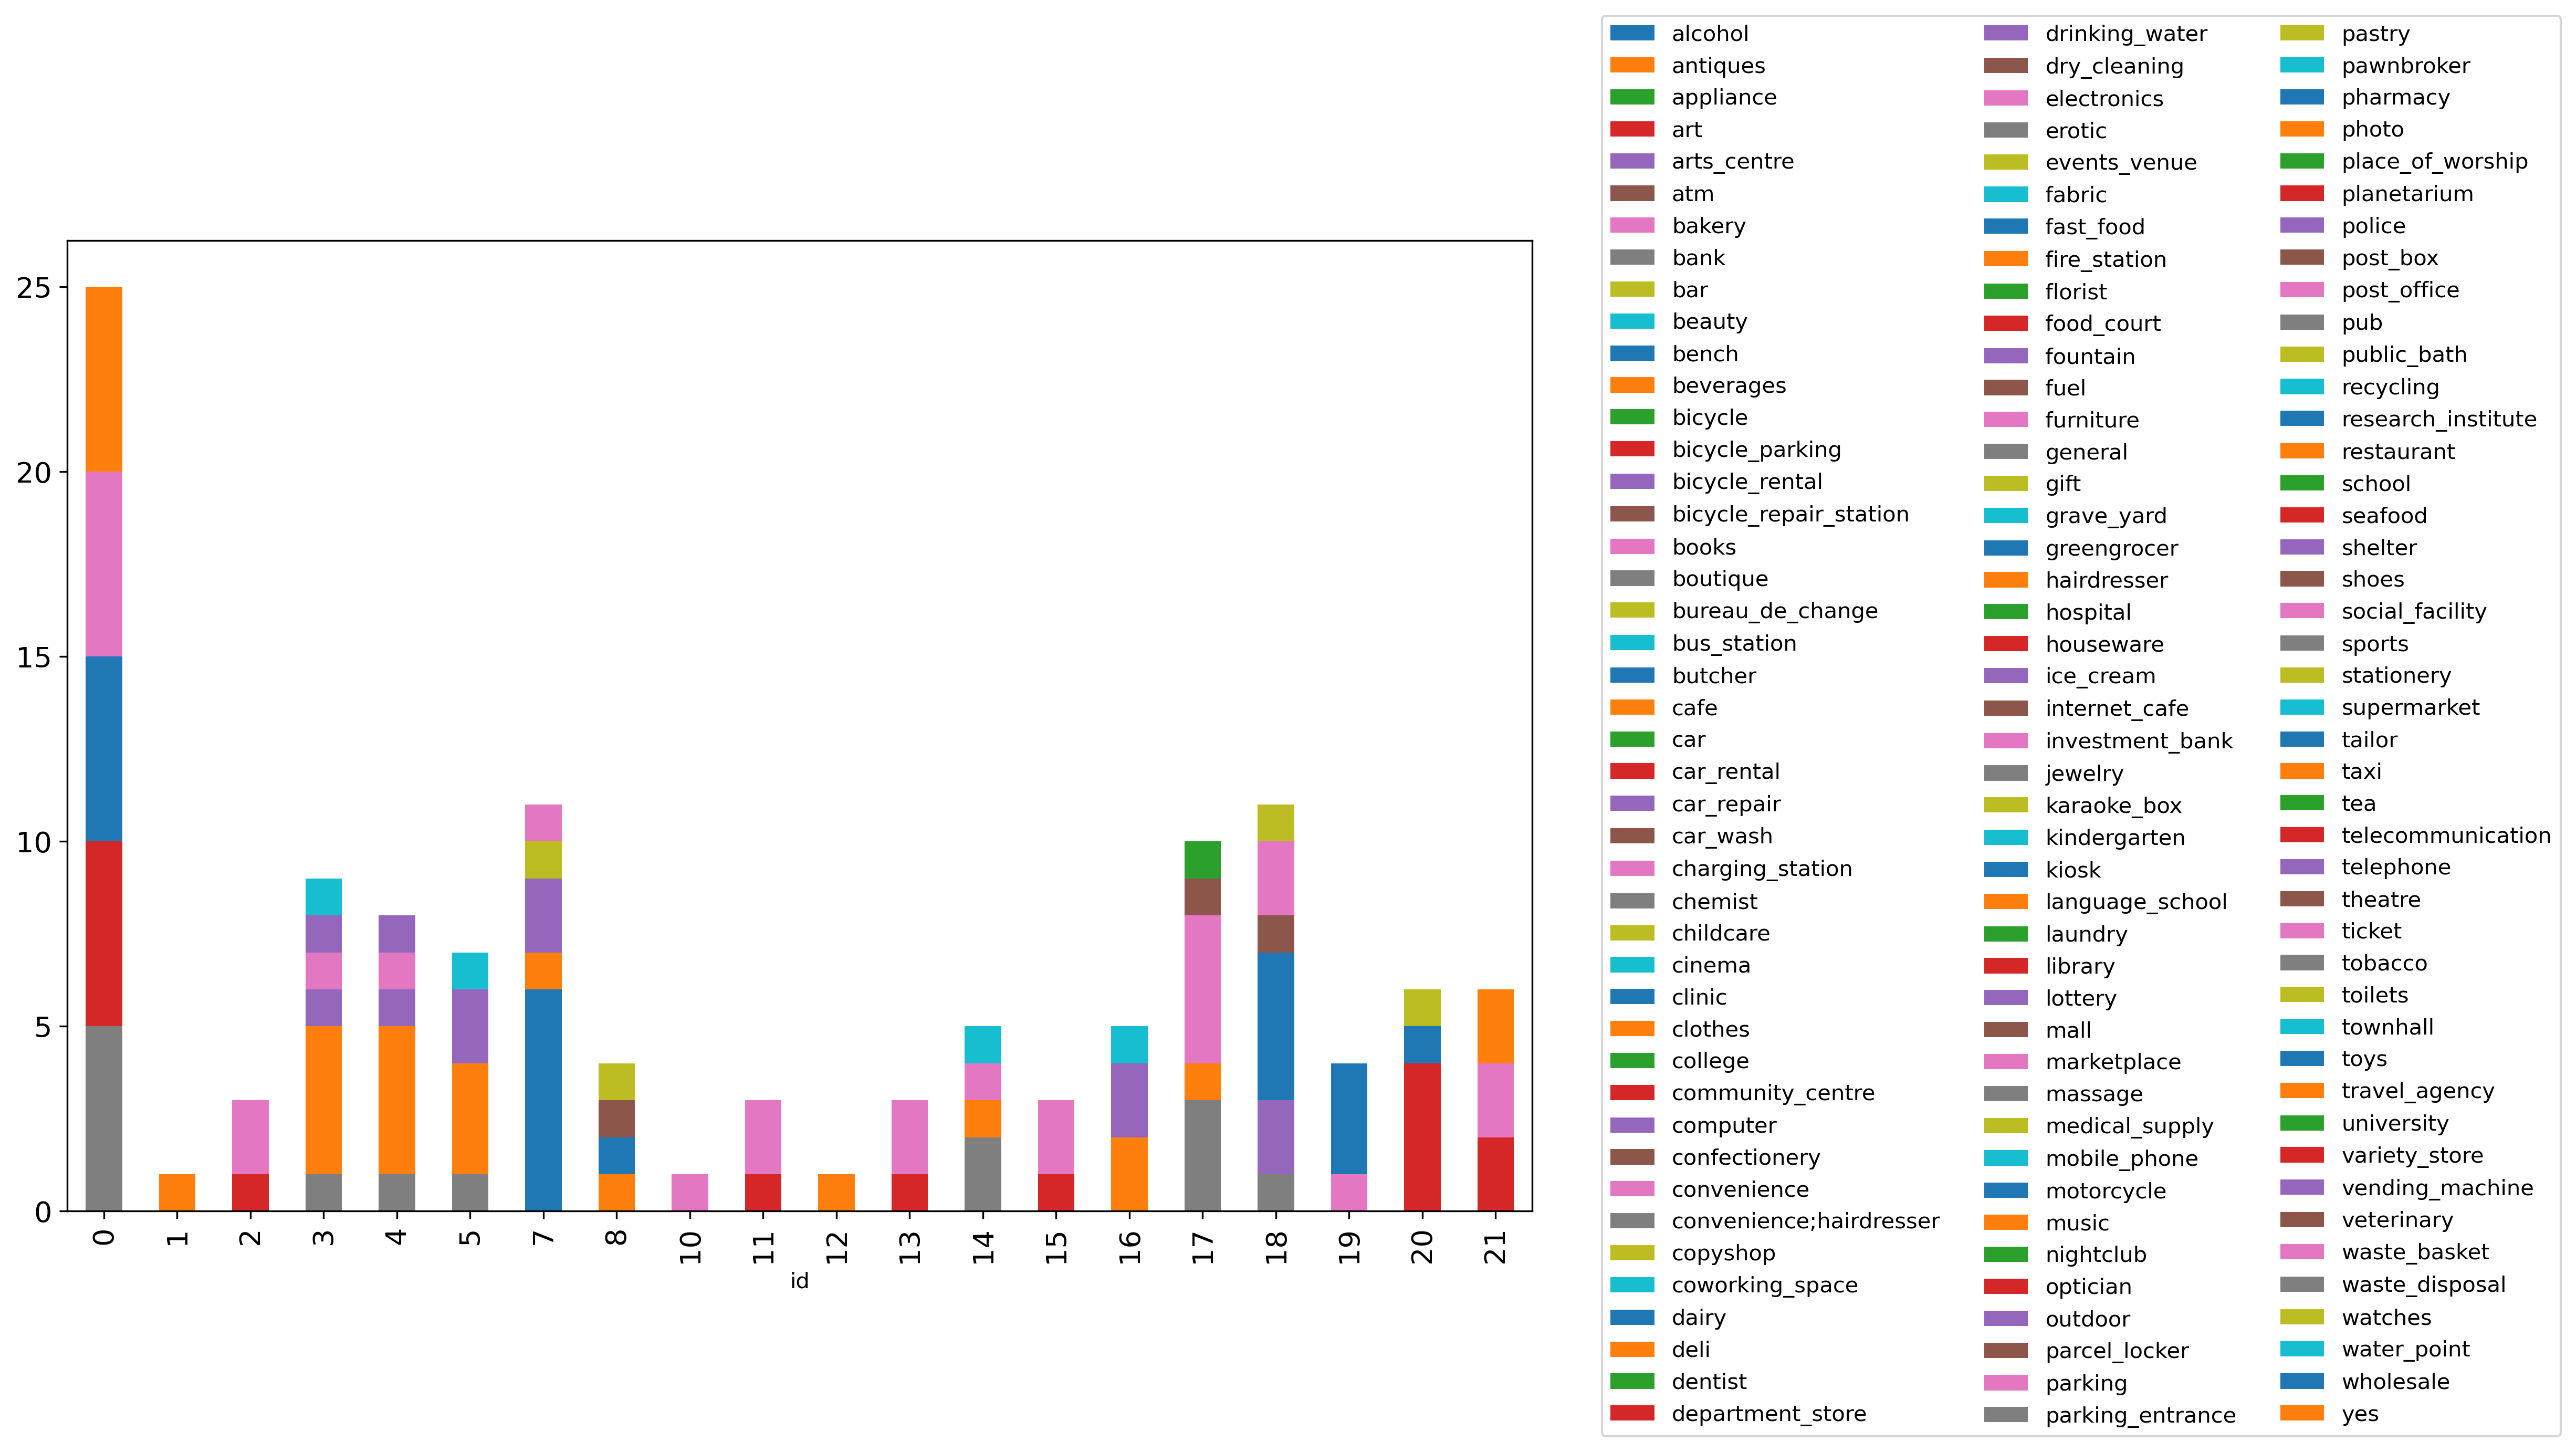

In [14]:
poi_types_per_loc = locs_pois.groupby(['id', 'poi_type'])['id'].count().unstack('poi_type').head(20)
poi_types_per_loc.plot(kind='bar', stacked=True, figsize=(12, 8))
plt.legend(ncol=3, loc='center left', bbox_to_anchor=(1.04, 0.5))
plt.show()